In [ ]:
!git clone https://github.com/garima-mahato/ERA_V1.git

Cloning into 'ERA_V1'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 152 (delta 68), reused 78 (delta 21), pack-reused 0
Receiving objects: 100% (152/152), 2.40 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [ ]:
from ERA_V1.Session7_InDepthCodingPractice import *

CODE BLOCK: 2

In [ ]:

# # CUDA?

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

device = set_device()

CUDA Available? True


CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    #transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 96563963.95it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43247302.33it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26310871.08it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16710990.15it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [ ]:
# set seed
torch.manual_seed(1)

batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

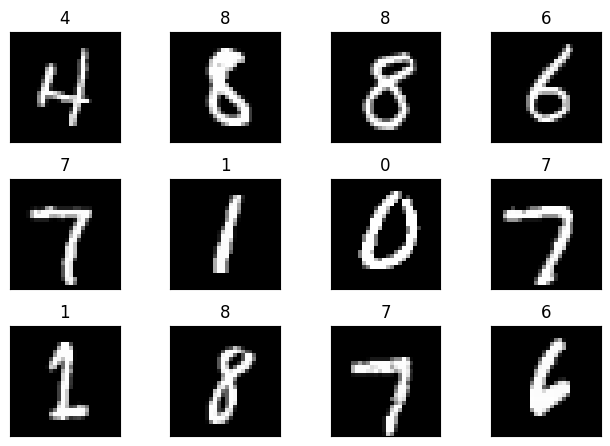

In [ ]:


view_data(train_loader)

CODE BLOCK: 8

CODE BLOCK: 9

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model_3(nn.Module):

    def __init__(self, dropout_value=0):
        super(Model_3, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # input_size = 28x28x1, output_size = 26x26x16, RF = 3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 26x26x16, output_size = 24x24x24, RF = 5x5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 24x24x24, output_size = 24x24x10, RF = 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24x24x10, output_size = 12x12x10, RF = 6x6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # input_size = 12x12x10, output_size = 10x10x14, RF = 10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # input_size = 6x6x16, output_size = 1x1x16, RF = 38x38

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x32, RF = 38x38

        self.dropout = nn.Dropout(dropout_value)


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary

model = Model_3().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
    

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  test(model, device, test_loader, test_acc, test_losses)
  #scheduler.step()

Epoch 1


Train: Loss=1.1323 Batch_id=117 Accuracy=52.02: 100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


Test set: Average loss: 0.9900, Accuracy: 7677/10000 (76.77%)

Epoch 2


Train: Loss=0.3564 Batch_id=117 Accuracy=88.97: 100%|██████████| 118/118 [00:19<00:00,  6.21it/s]


Test set: Average loss: 0.3249, Accuracy: 9546/10000 (95.46%)

Epoch 3


Train: Loss=0.3334 Batch_id=117 Accuracy=95.40: 100%|██████████| 118/118 [00:18<00:00,  6.40it/s]


Test set: Average loss: 0.1984, Accuracy: 9608/10000 (96.08%)

Epoch 4


Train: Loss=0.2421 Batch_id=117 Accuracy=96.61: 100%|██████████| 118/118 [00:19<00:00,  6.09it/s]


Test set: Average loss: 0.1600, Accuracy: 9656/10000 (96.56%)

Epoch 5


Train: Loss=0.1869 Batch_id=117 Accuracy=97.11: 100%|██████████| 118/118 [00:18<00:00,  6.40it/s]


Test set: Average loss: 0.1078, Accuracy: 9765/10000 (97.65%)

Epoch 6


Train: Loss=0.0991 Batch_id=117 Accuracy=97.54: 100%|██████████| 118/118 [00:18<00:00,  6.52it/s]


Test set: Average loss: 0.1042, Accuracy: 9751/10000 (97.51%)

Epoch 7


Train: Loss=0.0648 Batch_id=117 Accuracy=97.80: 100%|██████████| 118/118 [00:18<00:00,  6.33it/s]


Test set: Average loss: 0.0832, Accuracy: 9796/10000 (97.96%)

Epoch 8


Train: Loss=0.0650 Batch_id=117 Accuracy=97.95: 100%|██████████| 118/118 [00:18<00:00,  6.32it/s]


Test set: Average loss: 0.0844, Accuracy: 9767/10000 (97.67%)

Epoch 9


Train: Loss=0.0372 Batch_id=117 Accuracy=98.11: 100%|██████████| 118/118 [00:17<00:00,  6.58it/s]


Test set: Average loss: 0.0711, Accuracy: 9833/10000 (98.33%)

Epoch 10


Train: Loss=0.0659 Batch_id=117 Accuracy=98.26: 100%|██████████| 118/118 [00:18<00:00,  6.39it/s]


Test set: Average loss: 0.0642, Accuracy: 9829/10000 (98.29%)

Epoch 11


Train: Loss=0.0731 Batch_id=117 Accuracy=98.34: 100%|██████████| 118/118 [00:18<00:00,  6.22it/s]


Test set: Average loss: 0.0636, Accuracy: 9844/10000 (98.44%)

Epoch 12


Train: Loss=0.0495 Batch_id=117 Accuracy=98.36: 100%|██████████| 118/118 [00:18<00:00,  6.55it/s]


Test set: Average loss: 0.0582, Accuracy: 9839/10000 (98.39%)

Epoch 13


Train: Loss=0.0581 Batch_id=117 Accuracy=98.49: 100%|██████████| 118/118 [00:18<00:00,  6.42it/s]


Test set: Average loss: 0.0715, Accuracy: 9802/10000 (98.02%)

Epoch 14


Train: Loss=0.0246 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:18<00:00,  6.32it/s]


Test set: Average loss: 0.0742, Accuracy: 9800/10000 (98.00%)

Epoch 15


Train: Loss=0.0527 Batch_id=117 Accuracy=98.67: 100%|██████████| 118/118 [00:17<00:00,  6.68it/s]


Test set: Average loss: 0.0510, Accuracy: 9857/10000 (98.57%)



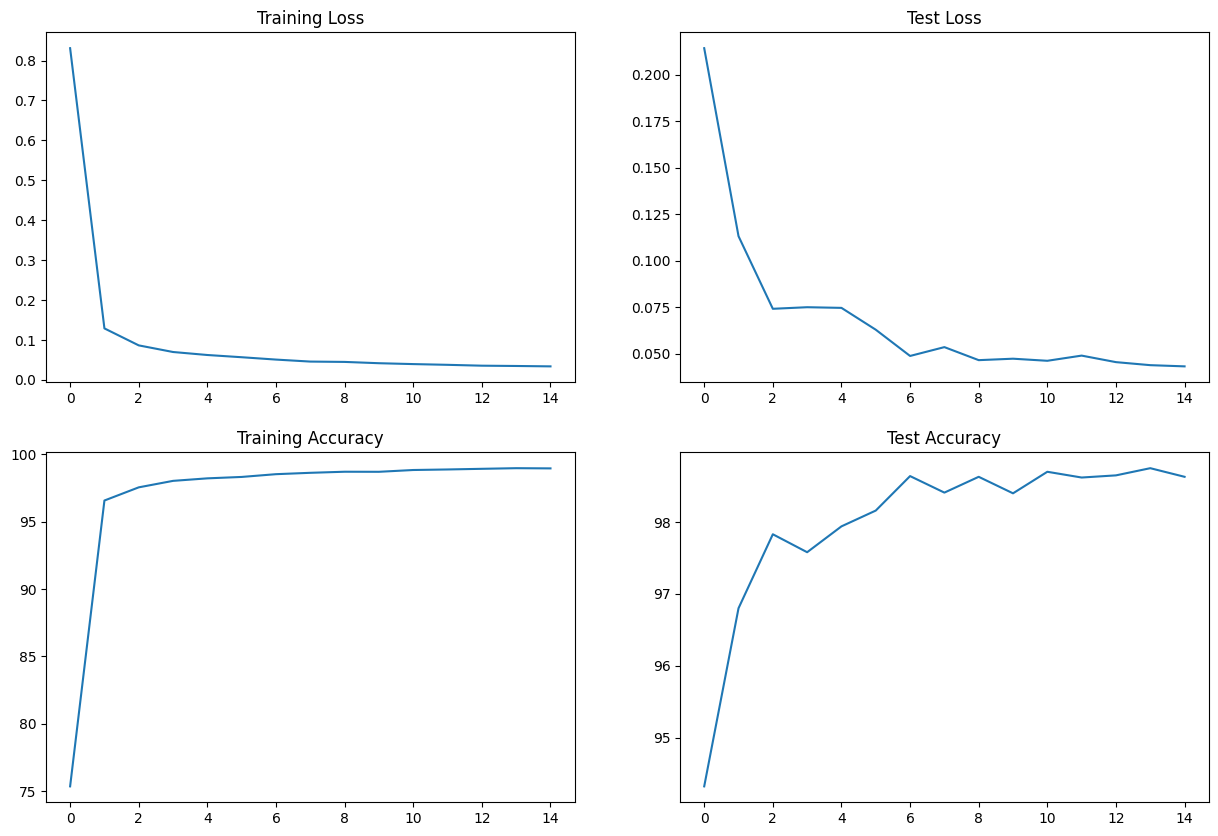

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 50

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  test(model, device, test_loader, test_acc, test_losses)
  #scheduler.step()

Epoch 1


Train: Loss=0.9544 Batch_id=117 Accuracy=54.12: 100%|██████████| 118/118 [00:18<00:00,  6.31it/s]


Test set: Average loss: 1.0140, Accuracy: 7370/10000 (73.70%)

Epoch 2


Train: Loss=0.4099 Batch_id=117 Accuracy=88.79: 100%|██████████| 118/118 [00:18<00:00,  6.30it/s]


Test set: Average loss: 0.3883, Accuracy: 9279/10000 (92.79%)

Epoch 3


Train: Loss=0.3622 Batch_id=117 Accuracy=94.56: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]


Test set: Average loss: 0.2092, Accuracy: 9571/10000 (95.71%)

Epoch 4


Train: Loss=0.1993 Batch_id=117 Accuracy=96.20: 100%|██████████| 118/118 [00:19<00:00,  5.98it/s]


Test set: Average loss: 0.1682, Accuracy: 9617/10000 (96.17%)

Epoch 5


Train: Loss=0.1725 Batch_id=117 Accuracy=96.89: 100%|██████████| 118/118 [00:18<00:00,  6.26it/s]


Test set: Average loss: 0.1557, Accuracy: 9600/10000 (96.00%)

Epoch 6


Train: Loss=0.1033 Batch_id=117 Accuracy=97.40: 100%|██████████| 118/118 [00:18<00:00,  6.24it/s]


Test set: Average loss: 0.1414, Accuracy: 9624/10000 (96.24%)

Epoch 7


Train: Loss=0.1053 Batch_id=117 Accuracy=97.64: 100%|██████████| 118/118 [00:19<00:00,  6.03it/s]


Test set: Average loss: 0.1018, Accuracy: 9731/10000 (97.31%)

Epoch 8


Train: Loss=0.0655 Batch_id=117 Accuracy=97.90: 100%|██████████| 118/118 [00:19<00:00,  6.05it/s]


Test set: Average loss: 0.0863, Accuracy: 9781/10000 (97.81%)

Epoch 9


Train: Loss=0.0338 Batch_id=117 Accuracy=98.09: 100%|██████████| 118/118 [00:18<00:00,  6.25it/s]


Test set: Average loss: 0.0870, Accuracy: 9776/10000 (97.76%)

Epoch 10


Train: Loss=0.0782 Batch_id=117 Accuracy=98.17: 100%|██████████| 118/118 [00:19<00:00,  6.20it/s]


Test set: Average loss: 0.0742, Accuracy: 9810/10000 (98.10%)

Epoch 11


Train: Loss=0.1260 Batch_id=117 Accuracy=98.28: 100%|██████████| 118/118 [00:19<00:00,  6.00it/s]


Test set: Average loss: 0.0746, Accuracy: 9803/10000 (98.03%)

Epoch 12


Train: Loss=0.1105 Batch_id=117 Accuracy=98.35: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


Test set: Average loss: 0.0796, Accuracy: 9791/10000 (97.91%)

Epoch 13


Train: Loss=0.0257 Batch_id=117 Accuracy=98.46: 100%|██████████| 118/118 [00:18<00:00,  6.28it/s]


Test set: Average loss: 0.0759, Accuracy: 9792/10000 (97.92%)

Epoch 14


Train: Loss=0.0673 Batch_id=117 Accuracy=98.52: 100%|██████████| 118/118 [00:19<00:00,  5.99it/s]


Test set: Average loss: 0.0719, Accuracy: 9809/10000 (98.09%)

Epoch 15


Train: Loss=0.2129 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:19<00:00,  6.01it/s]


Test set: Average loss: 0.0593, Accuracy: 9834/10000 (98.34%)

Epoch 16


Train: Loss=0.0646 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:18<00:00,  6.22it/s]


Test set: Average loss: 0.0614, Accuracy: 9833/10000 (98.33%)

Epoch 17


Train: Loss=0.0764 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:18<00:00,  6.22it/s]


Test set: Average loss: 0.0596, Accuracy: 9843/10000 (98.43%)

Epoch 18


Train: Loss=0.1163 Batch_id=117 Accuracy=98.73: 100%|██████████| 118/118 [00:19<00:00,  6.02it/s]


Test set: Average loss: 0.0707, Accuracy: 9805/10000 (98.05%)

Epoch 19


Train: Loss=0.0801 Batch_id=117 Accuracy=98.76: 100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


Test set: Average loss: 0.0542, Accuracy: 9847/10000 (98.47%)

Epoch 20


Train: Loss=0.0427 Batch_id=117 Accuracy=98.81: 100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


Test set: Average loss: 0.0554, Accuracy: 9843/10000 (98.43%)

Epoch 21


Train: Loss=0.0700 Batch_id=117 Accuracy=98.89: 100%|██████████| 118/118 [00:18<00:00,  6.30it/s]


Test set: Average loss: 0.0585, Accuracy: 9838/10000 (98.38%)

Epoch 22


Train: Loss=0.0379 Batch_id=117 Accuracy=98.90: 100%|██████████| 118/118 [00:19<00:00,  6.03it/s]


Test set: Average loss: 0.0508, Accuracy: 9862/10000 (98.62%)

Epoch 23


Train: Loss=0.0405 Batch_id=117 Accuracy=98.91: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


Test set: Average loss: 0.0512, Accuracy: 9853/10000 (98.53%)

Epoch 24


Train: Loss=0.0193 Batch_id=117 Accuracy=98.94: 100%|██████████| 118/118 [00:18<00:00,  6.26it/s]


Test set: Average loss: 0.0488, Accuracy: 9869/10000 (98.69%)

Epoch 25


Train: Loss=0.0366 Batch_id=117 Accuracy=98.94: 100%|██████████| 118/118 [00:19<00:00,  6.21it/s]


Test set: Average loss: 0.0605, Accuracy: 9807/10000 (98.07%)

Epoch 26


Train: Loss=0.0163 Batch_id=117 Accuracy=98.98: 100%|██████████| 118/118 [00:19<00:00,  5.98it/s]


Test set: Average loss: 0.0440, Accuracy: 9870/10000 (98.70%)

Epoch 27


Train: Loss=0.0361 Batch_id=117 Accuracy=99.05: 100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


Test set: Average loss: 0.0498, Accuracy: 9858/10000 (98.58%)

Epoch 28


Train: Loss=0.0962 Batch_id=117 Accuracy=99.05: 100%|██████████| 118/118 [00:18<00:00,  6.23it/s]


Test set: Average loss: 0.0498, Accuracy: 9859/10000 (98.59%)

Epoch 29


Train: Loss=0.0503 Batch_id=117 Accuracy=99.05: 100%|██████████| 118/118 [00:19<00:00,  6.11it/s]


Test set: Average loss: 0.0473, Accuracy: 9854/10000 (98.54%)

Epoch 30


Train: Loss=0.0500 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


Test set: Average loss: 0.0494, Accuracy: 9851/10000 (98.51%)

Epoch 31


Train: Loss=0.0191 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


Test set: Average loss: 0.0437, Accuracy: 9876/10000 (98.76%)

Epoch 32


Train: Loss=0.0509 Batch_id=117 Accuracy=99.14: 100%|██████████| 118/118 [00:18<00:00,  6.26it/s]


Test set: Average loss: 0.0440, Accuracy: 9874/10000 (98.74%)

Epoch 33


Train: Loss=0.0192 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]


Test set: Average loss: 0.0537, Accuracy: 9838/10000 (98.38%)

Epoch 34


Train: Loss=0.0451 Batch_id=117 Accuracy=99.14: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


Test set: Average loss: 0.0489, Accuracy: 9852/10000 (98.52%)

Epoch 35


Train: Loss=0.0360 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:19<00:00,  6.12it/s]


Test set: Average loss: 0.0429, Accuracy: 9869/10000 (98.69%)

Epoch 36


Train: Loss=0.0551 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:19<00:00,  6.21it/s]


Test set: Average loss: 0.0477, Accuracy: 9869/10000 (98.69%)

Epoch 37


Train: Loss=0.0156 Batch_id=117 Accuracy=99.18: 100%|██████████| 118/118 [00:20<00:00,  5.85it/s]


Test set: Average loss: 0.0490, Accuracy: 9855/10000 (98.55%)

Epoch 38


Train: Loss=0.0090 Batch_id=117 Accuracy=99.25: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


Test set: Average loss: 0.0444, Accuracy: 9859/10000 (98.59%)

Epoch 39


Train: Loss=0.0292 Batch_id=117 Accuracy=99.24: 100%|██████████| 118/118 [00:19<00:00,  6.01it/s]


Test set: Average loss: 0.0448, Accuracy: 9872/10000 (98.72%)

Epoch 40


Train: Loss=0.0193 Batch_id=117 Accuracy=99.25: 100%|██████████| 118/118 [00:18<00:00,  6.29it/s]


Test set: Average loss: 0.0429, Accuracy: 9868/10000 (98.68%)

Epoch 41


Train: Loss=0.0331 Batch_id=117 Accuracy=99.24: 100%|██████████| 118/118 [00:19<00:00,  6.18it/s]


Test set: Average loss: 0.0443, Accuracy: 9861/10000 (98.61%)

Epoch 42


Train: Loss=0.0211 Batch_id=117 Accuracy=99.30: 100%|██████████| 118/118 [00:19<00:00,  6.05it/s]


Test set: Average loss: 0.0407, Accuracy: 9878/10000 (98.78%)

Epoch 43


Train: Loss=0.0656 Batch_id=117 Accuracy=99.25: 100%|██████████| 118/118 [00:19<00:00,  6.04it/s]


Test set: Average loss: 0.0406, Accuracy: 9880/10000 (98.80%)

Epoch 44


Train: Loss=0.0538 Batch_id=117 Accuracy=99.28: 100%|██████████| 118/118 [00:18<00:00,  6.25it/s]


Test set: Average loss: 0.0407, Accuracy: 9875/10000 (98.75%)

Epoch 45


Train: Loss=0.0156 Batch_id=117 Accuracy=99.32: 100%|██████████| 118/118 [00:20<00:00,  5.83it/s]


Test set: Average loss: 0.0382, Accuracy: 9885/10000 (98.85%)

Epoch 46


Train: Loss=0.0249 Batch_id=117 Accuracy=99.35: 100%|██████████| 118/118 [00:19<00:00,  6.04it/s]


Test set: Average loss: 0.0502, Accuracy: 9851/10000 (98.51%)

Epoch 47


Train: Loss=0.0411 Batch_id=117 Accuracy=99.30: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


Test set: Average loss: 0.0424, Accuracy: 9865/10000 (98.65%)

Epoch 48


Train: Loss=0.0191 Batch_id=117 Accuracy=99.33: 100%|██████████| 118/118 [00:18<00:00,  6.28it/s]


Test set: Average loss: 0.0431, Accuracy: 9863/10000 (98.63%)

Epoch 49


Train: Loss=0.0122 Batch_id=117 Accuracy=99.36: 100%|██████████| 118/118 [00:19<00:00,  6.18it/s]


Test set: Average loss: 0.0420, Accuracy: 9862/10000 (98.62%)

Epoch 50


Train: Loss=0.0594 Batch_id=117 Accuracy=99.34: 100%|██████████| 118/118 [00:19<00:00,  6.05it/s]


Test set: Average loss: 0.0391, Accuracy: 9881/10000 (98.81%)



In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.2260 Batch_id=117 Accuracy=80.25: 100%|██████████| 118/118 [00:18<00:00,  6.25it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.1668, Accuracy: 9501/10000 (95.01%)

Epoch 2


Train: Loss=0.0839 Batch_id=117 Accuracy=97.41: 100%|██████████| 118/118 [00:18<00:00,  6.30it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0954, Accuracy: 9701/10000 (97.01%)

Epoch 3


Train: Loss=0.1194 Batch_id=117 Accuracy=98.09: 100%|██████████| 118/118 [00:19<00:00,  6.01it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0559, Accuracy: 9835/10000 (98.35%)

Epoch 4


Train: Loss=0.0432 Batch_id=117 Accuracy=98.52: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0570, Accuracy: 9823/10000 (98.23%)

Epoch 5


Train: Loss=0.0815 Batch_id=117 Accuracy=98.91: 100%|██████████| 118/118 [00:18<00:00,  6.29it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0362, Accuracy: 9886/10000 (98.86%)

Epoch 6


Train: Loss=0.0623 Batch_id=117 Accuracy=99.00: 100%|██████████| 118/118 [00:18<00:00,  6.29it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0352, Accuracy: 9895/10000 (98.95%)

Epoch 7


Train: Loss=0.0181 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:19<00:00,  6.07it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0346, Accuracy: 9896/10000 (98.96%)

Epoch 8


Train: Loss=0.0167 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:19<00:00,  6.08it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0331, Accuracy: 9899/10000 (98.99%)

Epoch 9


Train: Loss=0.0502 Batch_id=117 Accuracy=99.13: 100%|██████████| 118/118 [00:18<00:00,  6.31it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0332, Accuracy: 9898/10000 (98.98%)

Epoch 10


Train: Loss=0.0818 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:19<00:00,  6.11it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0330, Accuracy: 9895/10000 (98.95%)

Epoch 11


Train: Loss=0.0126 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0334, Accuracy: 9895/10000 (98.95%)

Epoch 12


Train: Loss=0.0378 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:19<00:00,  6.15it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)

Epoch 13


Train: Loss=0.0247 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:18<00:00,  6.29it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0332, Accuracy: 9893/10000 (98.93%)

Epoch 14


Train: Loss=0.0593 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:19<00:00,  6.09it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)

Epoch 15


Train: Loss=0.0289 Batch_id=117 Accuracy=99.13: 100%|██████████| 118/118 [00:19<00:00,  6.05it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)



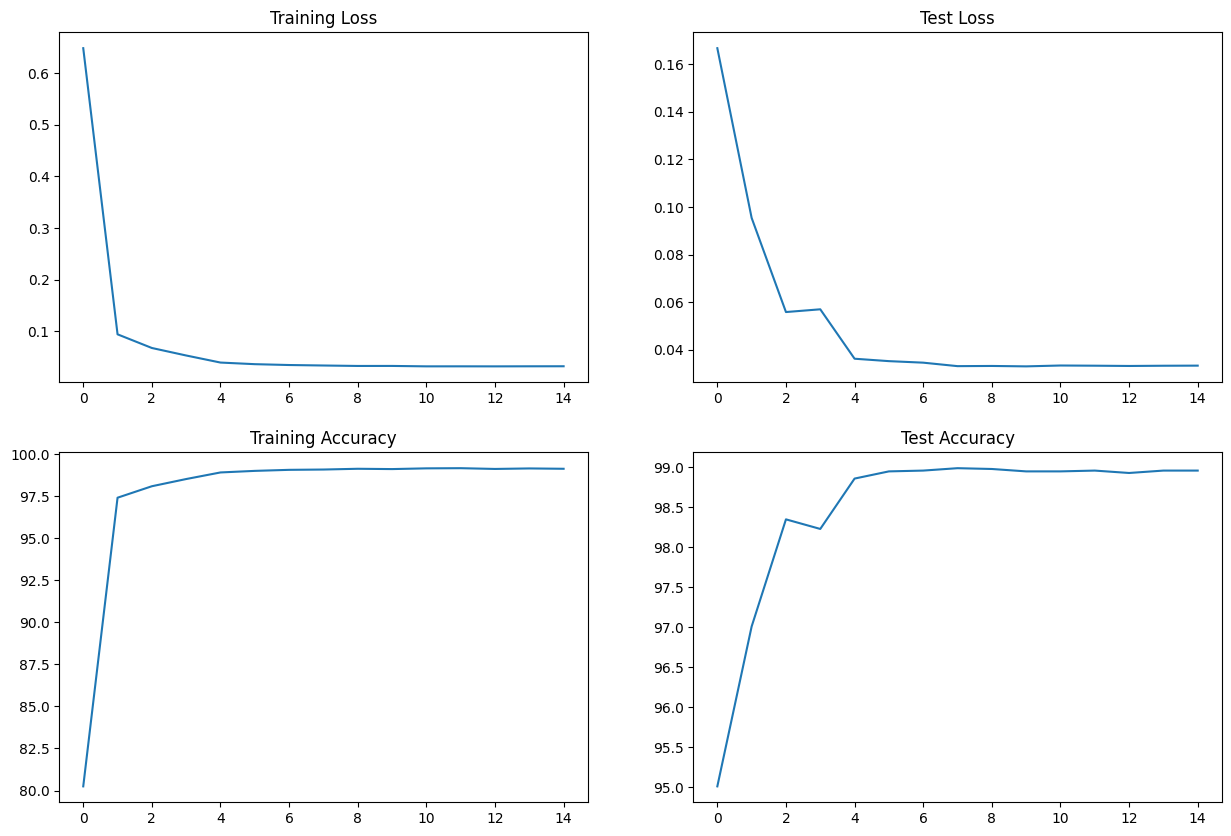

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

#### Trying with augmentation

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# set seed
torch.manual_seed(1)

batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  if epoch==4:
    scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.1683 Batch_id=117 Accuracy=78.19: 100%|██████████| 118/118 [00:27<00:00,  4.36it/s]


Test set: Average loss: 0.1597, Accuracy: 9511/10000 (95.11%)

Epoch 2


Train: Loss=0.0507 Batch_id=117 Accuracy=95.94: 100%|██████████| 118/118 [00:26<00:00,  4.46it/s]


Test set: Average loss: 0.0976, Accuracy: 9691/10000 (96.91%)

Epoch 3


Train: Loss=0.0598 Batch_id=117 Accuracy=96.93: 100%|██████████| 118/118 [00:28<00:00,  4.10it/s]


Test set: Average loss: 0.1271, Accuracy: 9632/10000 (96.32%)

Epoch 4


Train: Loss=0.0532 Batch_id=117 Accuracy=97.48: 100%|██████████| 118/118 [00:26<00:00,  4.47it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0639, Accuracy: 9807/10000 (98.07%)

Epoch 5


Train: Loss=0.0449 Batch_id=117 Accuracy=97.72: 100%|██████████| 118/118 [00:26<00:00,  4.45it/s]


Test set: Average loss: 0.0562, Accuracy: 9831/10000 (98.31%)

Epoch 6


Train: Loss=0.0919 Batch_id=117 Accuracy=97.90: 100%|██████████| 118/118 [00:26<00:00,  4.47it/s]


Test set: Average loss: 0.0708, Accuracy: 9765/10000 (97.65%)

Epoch 7


Train: Loss=0.0867 Batch_id=117 Accuracy=97.86: 100%|██████████| 118/118 [00:26<00:00,  4.43it/s]


Test set: Average loss: 0.0430, Accuracy: 9865/10000 (98.65%)

Epoch 8


Train: Loss=0.0748 Batch_id=117 Accuracy=98.08: 100%|██████████| 118/118 [00:26<00:00,  4.47it/s]


Test set: Average loss: 0.0508, Accuracy: 9839/10000 (98.39%)

Epoch 9


Train: Loss=0.0424 Batch_id=117 Accuracy=98.24: 100%|██████████| 118/118 [00:27<00:00,  4.35it/s]


Test set: Average loss: 0.0337, Accuracy: 9887/10000 (98.87%)

Epoch 10


Train: Loss=0.0366 Batch_id=117 Accuracy=98.25: 100%|██████████| 118/118 [00:26<00:00,  4.49it/s]


Test set: Average loss: 0.0401, Accuracy: 9874/10000 (98.74%)

Epoch 11


Train: Loss=0.0367 Batch_id=117 Accuracy=98.42: 100%|██████████| 118/118 [00:30<00:00,  3.90it/s]


Test set: Average loss: 0.0402, Accuracy: 9871/10000 (98.71%)

Epoch 12


Train: Loss=0.0698 Batch_id=117 Accuracy=98.44: 100%|██████████| 118/118 [00:27<00:00,  4.32it/s]


Test set: Average loss: 0.0389, Accuracy: 9866/10000 (98.66%)

Epoch 13


Train: Loss=0.0206 Batch_id=117 Accuracy=98.50: 100%|██████████| 118/118 [00:28<00:00,  4.14it/s]


Test set: Average loss: 0.0354, Accuracy: 9890/10000 (98.90%)

Epoch 14


Train: Loss=0.0101 Batch_id=117 Accuracy=98.53: 100%|██████████| 118/118 [00:28<00:00,  4.21it/s]


Test set: Average loss: 0.0295, Accuracy: 9898/10000 (98.98%)

Epoch 15


Train: Loss=0.0393 Batch_id=117 Accuracy=98.55: 100%|██████████| 118/118 [00:29<00:00,  4.06it/s]


Test set: Average loss: 0.0303, Accuracy: 9898/10000 (98.98%)



---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model_4(nn.Module):

    def __init__(self, dropout_value=0):
        super(Model_4, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Dropout(dropout_value)
        ) # input_size = 28x28x1, output_size = 26x26x16, RF = 3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # input_size = 26x26x16, output_size = 24x24x24, RF = 5x5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 24x24x24, output_size = 24x24x10, RF = 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24x24x10, output_size = 12x12x10, RF = 6x6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # input_size = 12x12x10, output_size = 10x10x14, RF = 10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # input_size = 6x6x16, output_size = 1x1x16, RF = 38x38

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x32, RF = 38x38

        self.dropout = nn.Dropout(dropout_value)


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary

model = Model_4().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
       BatchNorm2d-3            [-1, 6, 26, 26]              12
           Dropout-4            [-1, 6, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             432
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]              80
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
    

In [ ]:
model = Model_4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  test(model, device, test_loader, test_acc, test_losses)
  #scheduler.step()

Epoch 1


Train: Loss=0.7314 Batch_id=117 Accuracy=60.37: 100%|██████████| 118/118 [00:18<00:00,  6.33it/s]


Test set: Average loss: 0.7354, Accuracy: 8798/10000 (87.98%)

Epoch 2


Train: Loss=0.2997 Batch_id=117 Accuracy=91.79: 100%|██████████| 118/118 [00:19<00:00,  6.21it/s]


Test set: Average loss: 0.2610, Accuracy: 9476/10000 (94.76%)

Epoch 3


Train: Loss=0.2151 Batch_id=117 Accuracy=95.10: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]


Test set: Average loss: 0.1702, Accuracy: 9628/10000 (96.28%)

Epoch 4


Train: Loss=0.1351 Batch_id=117 Accuracy=96.12: 100%|██████████| 118/118 [00:18<00:00,  6.48it/s]


Test set: Average loss: 0.1360, Accuracy: 9675/10000 (96.75%)

Epoch 5


Train: Loss=0.0819 Batch_id=117 Accuracy=96.82: 100%|██████████| 118/118 [00:18<00:00,  6.22it/s]


Test set: Average loss: 0.1137, Accuracy: 9717/10000 (97.17%)

Epoch 6


Train: Loss=0.0953 Batch_id=117 Accuracy=97.16: 100%|██████████| 118/118 [00:17<00:00,  6.67it/s]


Test set: Average loss: 0.0985, Accuracy: 9763/10000 (97.63%)

Epoch 7


Train: Loss=0.1019 Batch_id=117 Accuracy=97.38: 100%|██████████| 118/118 [00:18<00:00,  6.41it/s]


Test set: Average loss: 0.0937, Accuracy: 9740/10000 (97.40%)

Epoch 8


Train: Loss=0.0485 Batch_id=117 Accuracy=97.55: 100%|██████████| 118/118 [00:18<00:00,  6.45it/s]


Test set: Average loss: 0.0871, Accuracy: 9776/10000 (97.76%)

Epoch 9


Train: Loss=0.1296 Batch_id=117 Accuracy=97.76: 100%|██████████| 118/118 [00:17<00:00,  6.70it/s]


Test set: Average loss: 0.0790, Accuracy: 9780/10000 (97.80%)

Epoch 10


Train: Loss=0.1017 Batch_id=117 Accuracy=97.94: 100%|██████████| 118/118 [00:17<00:00,  6.67it/s]


Test set: Average loss: 0.0754, Accuracy: 9813/10000 (98.13%)

Epoch 11


Train: Loss=0.0600 Batch_id=117 Accuracy=98.02: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]


Test set: Average loss: 0.0717, Accuracy: 9801/10000 (98.01%)

Epoch 12


Train: Loss=0.1057 Batch_id=117 Accuracy=98.16: 100%|██████████| 118/118 [00:17<00:00,  6.73it/s]


Test set: Average loss: 0.0672, Accuracy: 9827/10000 (98.27%)

Epoch 13


Train: Loss=0.0763 Batch_id=117 Accuracy=98.19: 100%|██████████| 118/118 [00:18<00:00,  6.55it/s]


Test set: Average loss: 0.0658, Accuracy: 9820/10000 (98.20%)

Epoch 14


Train: Loss=0.0704 Batch_id=117 Accuracy=98.34: 100%|██████████| 118/118 [00:18<00:00,  6.47it/s]


Test set: Average loss: 0.0639, Accuracy: 9832/10000 (98.32%)

Epoch 15


Train: Loss=0.0376 Batch_id=117 Accuracy=98.47: 100%|██████████| 118/118 [00:17<00:00,  6.71it/s]


Test set: Average loss: 0.0607, Accuracy: 9830/10000 (98.30%)



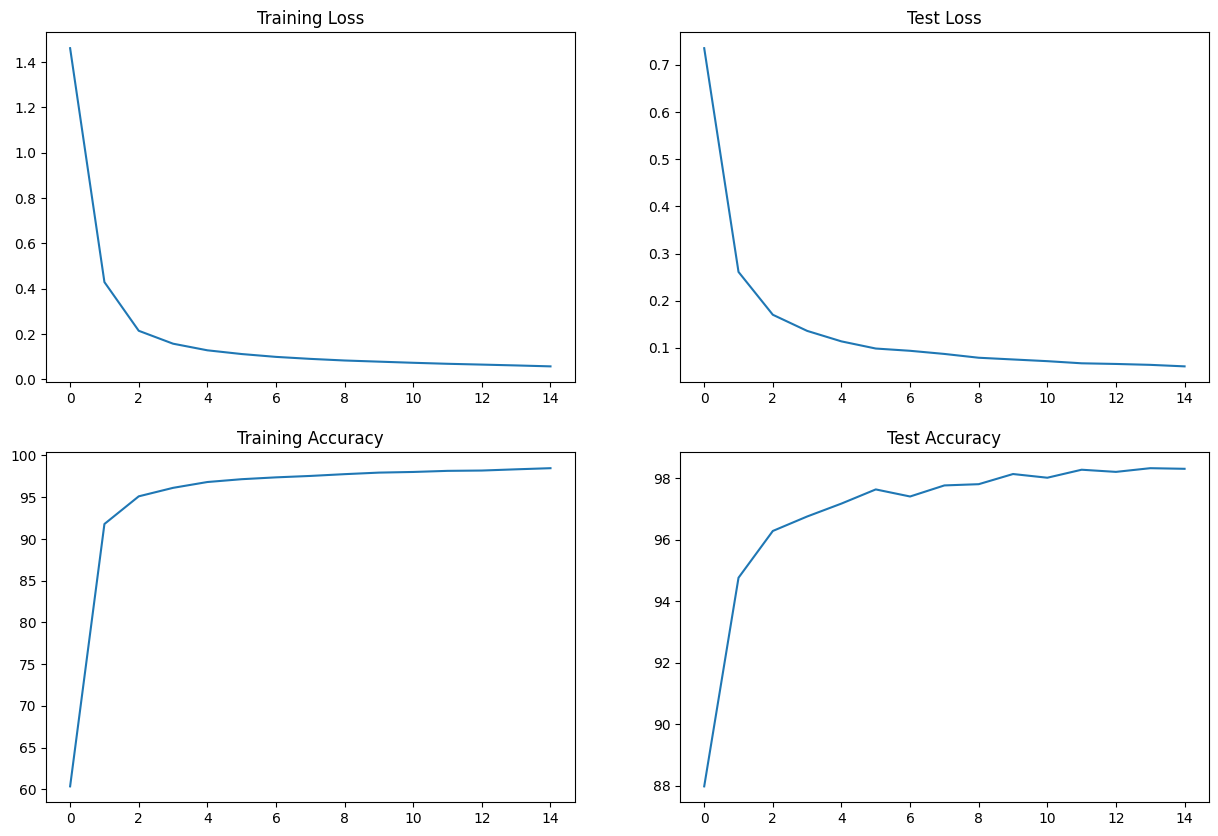

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    #transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# set seed
torch.manual_seed(1)

batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Model_4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  test(model, device, test_loader, test_acc, test_losses)
  #scheduler.step()

Epoch 1


Train: Loss=0.8142 Batch_id=117 Accuracy=57.51: 100%|██████████| 118/118 [00:18<00:00,  6.29it/s]


Test set: Average loss: 0.7882, Accuracy: 8571/10000 (85.71%)

Epoch 2


Train: Loss=0.4057 Batch_id=117 Accuracy=91.38: 100%|██████████| 118/118 [00:19<00:00,  6.04it/s]


Test set: Average loss: 0.2546, Accuracy: 9440/10000 (94.40%)

Epoch 3


Train: Loss=0.1096 Batch_id=117 Accuracy=95.48: 100%|██████████| 118/118 [00:19<00:00,  6.10it/s]


Test set: Average loss: 0.1586, Accuracy: 9643/10000 (96.43%)

Epoch 4


Train: Loss=0.1218 Batch_id=117 Accuracy=96.62: 100%|██████████| 118/118 [00:18<00:00,  6.24it/s]


Test set: Average loss: 0.1219, Accuracy: 9709/10000 (97.09%)

Epoch 5


Train: Loss=0.1136 Batch_id=117 Accuracy=97.11: 100%|██████████| 118/118 [00:19<00:00,  6.13it/s]


Test set: Average loss: 0.1130, Accuracy: 9725/10000 (97.25%)

Epoch 6


Train: Loss=0.1443 Batch_id=117 Accuracy=97.48: 100%|██████████| 118/118 [00:19<00:00,  6.13it/s]


Test set: Average loss: 0.1032, Accuracy: 9725/10000 (97.25%)

Epoch 7


Train: Loss=0.1105 Batch_id=117 Accuracy=97.69: 100%|██████████| 118/118 [00:18<00:00,  6.34it/s]


Test set: Average loss: 0.0877, Accuracy: 9780/10000 (97.80%)

Epoch 8


Train: Loss=0.0567 Batch_id=117 Accuracy=97.84: 100%|██████████| 118/118 [00:19<00:00,  5.99it/s]


Test set: Average loss: 0.0775, Accuracy: 9823/10000 (98.23%)

Epoch 9


Train: Loss=0.0936 Batch_id=117 Accuracy=97.98: 100%|██████████| 118/118 [00:19<00:00,  6.20it/s]


Test set: Average loss: 0.0776, Accuracy: 9793/10000 (97.93%)

Epoch 10


Train: Loss=0.0633 Batch_id=117 Accuracy=98.11: 100%|██████████| 118/118 [00:18<00:00,  6.52it/s]


Test set: Average loss: 0.0690, Accuracy: 9815/10000 (98.15%)

Epoch 11


Train: Loss=0.0854 Batch_id=117 Accuracy=98.21: 100%|██████████| 118/118 [00:18<00:00,  6.54it/s]


Test set: Average loss: 0.0671, Accuracy: 9819/10000 (98.19%)

Epoch 12


Train: Loss=0.0920 Batch_id=117 Accuracy=98.27: 100%|██████████| 118/118 [00:19<00:00,  6.04it/s]


Test set: Average loss: 0.0626, Accuracy: 9832/10000 (98.32%)

Epoch 13


Train: Loss=0.0615 Batch_id=117 Accuracy=98.40: 100%|██████████| 118/118 [00:19<00:00,  5.99it/s]


Test set: Average loss: 0.0691, Accuracy: 9814/10000 (98.14%)

Epoch 14


Train: Loss=0.0427 Batch_id=117 Accuracy=98.44: 100%|██████████| 118/118 [00:18<00:00,  6.31it/s]


Test set: Average loss: 0.0586, Accuracy: 9839/10000 (98.39%)

Epoch 15


Train: Loss=0.0272 Batch_id=117 Accuracy=98.47: 100%|██████████| 118/118 [00:18<00:00,  6.40it/s]


Test set: Average loss: 0.0563, Accuracy: 9829/10000 (98.29%)

Epoch 16


Train: Loss=0.0449 Batch_id=117 Accuracy=98.55: 100%|██████████| 118/118 [00:19<00:00,  5.98it/s]


Test set: Average loss: 0.0586, Accuracy: 9838/10000 (98.38%)

Epoch 17


Train: Loss=0.0659 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:19<00:00,  6.05it/s]


Test set: Average loss: 0.0549, Accuracy: 9844/10000 (98.44%)

Epoch 18


Train: Loss=0.0148 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:17<00:00,  6.64it/s]


Test set: Average loss: 0.0660, Accuracy: 9785/10000 (97.85%)

Epoch 19


Train: Loss=0.0192 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:19<00:00,  6.12it/s]


Test set: Average loss: 0.0547, Accuracy: 9826/10000 (98.26%)

Epoch 20


Train: Loss=0.0341 Batch_id=117 Accuracy=98.75: 100%|██████████| 118/118 [00:19<00:00,  6.19it/s]


Test set: Average loss: 0.0513, Accuracy: 9857/10000 (98.57%)



### Model 5 Basic Skeleton

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    #transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# set seed
torch.manual_seed(1)

batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model_5(nn.Module):

    def __init__(self, dropout_value=0):
        super(Model_5, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # input_size = 28x28x1, output_size = 26x26x16, RF = 3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 26x26x16, output_size = 24x24x24, RF = 5x5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 24x24x24, output_size = 24x24x10, RF = 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24x24x10, output_size = 12x12x10, RF = 6x6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # input_size = 12x12x10, output_size = 10x10x14, RF = 10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # input_size = 6x6x16, output_size = 1x1x16, RF = 38x38

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x32, RF = 38x38

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x32, RF = 38x38

        self.dropout = nn.Dropout(dropout_value)


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)

In [ ]:
model = Model_5().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1, 14,

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Model_5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  if epoch==4:
    scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.1479 Batch_id=117 Accuracy=84.60: 100%|██████████| 118/118 [00:19<00:00,  6.18it/s]


Test set: Average loss: 0.0806, Accuracy: 9738/10000 (97.38%)

Epoch 2


Train: Loss=0.0610 Batch_id=117 Accuracy=98.08: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]


Test set: Average loss: 0.0636, Accuracy: 9805/10000 (98.05%)

Epoch 3


Train: Loss=0.0495 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:18<00:00,  6.24it/s]


Test set: Average loss: 0.0498, Accuracy: 9858/10000 (98.58%)

Epoch 4


Train: Loss=0.0340 Batch_id=117 Accuracy=98.80: 100%|██████████| 118/118 [00:19<00:00,  6.19it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0369, Accuracy: 9894/10000 (98.94%)

Epoch 5


Train: Loss=0.0112 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:18<00:00,  6.32it/s]


Test set: Average loss: 0.0559, Accuracy: 9826/10000 (98.26%)

Epoch 6


Train: Loss=0.0029 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:18<00:00,  6.25it/s]


Test set: Average loss: 0.0400, Accuracy: 9871/10000 (98.71%)

Epoch 7


Train: Loss=0.0131 Batch_id=117 Accuracy=99.28: 100%|██████████| 118/118 [00:19<00:00,  6.13it/s]


Test set: Average loss: 0.0288, Accuracy: 9920/10000 (99.20%)

Epoch 8


Train: Loss=0.0440 Batch_id=117 Accuracy=99.29: 100%|██████████| 118/118 [00:19<00:00,  6.01it/s]


Test set: Average loss: 0.0312, Accuracy: 9902/10000 (99.02%)

Epoch 9


Train: Loss=0.0112 Batch_id=117 Accuracy=99.34: 100%|██████████| 118/118 [00:19<00:00,  6.02it/s]


Test set: Average loss: 0.0293, Accuracy: 9914/10000 (99.14%)

Epoch 10


Train: Loss=0.0398 Batch_id=117 Accuracy=99.35: 100%|██████████| 118/118 [00:18<00:00,  6.23it/s]


Test set: Average loss: 0.0291, Accuracy: 9917/10000 (99.17%)

Epoch 11


Train: Loss=0.0080 Batch_id=117 Accuracy=99.38: 100%|██████████| 118/118 [00:19<00:00,  6.00it/s]


Test set: Average loss: 0.0294, Accuracy: 9909/10000 (99.09%)

Epoch 12


Train: Loss=0.0106 Batch_id=117 Accuracy=99.50: 100%|██████████| 118/118 [00:19<00:00,  6.18it/s]


Test set: Average loss: 0.0370, Accuracy: 9886/10000 (98.86%)

Epoch 13


Train: Loss=0.0570 Batch_id=117 Accuracy=99.52: 100%|██████████| 118/118 [00:19<00:00,  6.03it/s]


Test set: Average loss: 0.0269, Accuracy: 9932/10000 (99.32%)

Epoch 14


Train: Loss=0.0333 Batch_id=117 Accuracy=99.52: 100%|██████████| 118/118 [00:18<00:00,  6.30it/s]


Test set: Average loss: 0.0340, Accuracy: 9906/10000 (99.06%)

Epoch 15


Train: Loss=0.0015 Batch_id=117 Accuracy=99.50: 100%|██████████| 118/118 [00:19<00:00,  6.09it/s]


Test set: Average loss: 0.0261, Accuracy: 9928/10000 (99.28%)



In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0.05

model = Model_5(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  #scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Epoch 1


Train: Loss=0.0576 Batch_id=117 Accuracy=79.11: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]


Test set: Average loss: 0.2434, Accuracy: 9260/10000 (92.60%)

Epoch 2


Train: Loss=0.1096 Batch_id=117 Accuracy=97.27: 100%|██████████| 118/118 [00:18<00:00,  6.28it/s]


Test set: Average loss: 0.0706, Accuracy: 9767/10000 (97.67%)

Epoch 3


Train: Loss=0.0968 Batch_id=117 Accuracy=97.91: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]


Test set: Average loss: 0.0637, Accuracy: 9805/10000 (98.05%)

Epoch 4


Train: Loss=0.1029 Batch_id=117 Accuracy=98.33: 100%|██████████| 118/118 [00:19<00:00,  6.05it/s]


Test set: Average loss: 0.0498, Accuracy: 9848/10000 (98.48%)

Epoch 5


Train: Loss=0.0324 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]


Test set: Average loss: 0.0471, Accuracy: 9850/10000 (98.50%)

Epoch 6


Train: Loss=0.0188 Batch_id=117 Accuracy=98.60: 100%|██████████| 118/118 [00:19<00:00,  6.14it/s]


Test set: Average loss: 0.0414, Accuracy: 9869/10000 (98.69%)

Epoch 7


Train: Loss=0.0345 Batch_id=117 Accuracy=98.75: 100%|██████████| 118/118 [00:18<00:00,  6.42it/s]


Test set: Average loss: 0.0386, Accuracy: 9884/10000 (98.84%)

Epoch 8


Train: Loss=0.0729 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:19<00:00,  6.10it/s]


Test set: Average loss: 0.0433, Accuracy: 9847/10000 (98.47%)

Epoch 9


Train: Loss=0.0294 Batch_id=117 Accuracy=98.86: 100%|██████████| 118/118 [00:18<00:00,  6.22it/s]


Test set: Average loss: 0.0396, Accuracy: 9864/10000 (98.64%)

Epoch 10


Train: Loss=0.0116 Batch_id=117 Accuracy=98.96: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]


Test set: Average loss: 0.0516, Accuracy: 9823/10000 (98.23%)

Epoch 11


Train: Loss=0.0514 Batch_id=117 Accuracy=98.94: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]


Test set: Average loss: 0.0352, Accuracy: 9883/10000 (98.83%)

Epoch 12


Train: Loss=0.0046 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:19<00:00,  6.19it/s]


Test set: Average loss: 0.0377, Accuracy: 9872/10000 (98.72%)

Epoch 13


Train: Loss=0.0207 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:18<00:00,  6.39it/s]


Test set: Average loss: 0.0339, Accuracy: 9878/10000 (98.78%)

Epoch 14


Train: Loss=0.0031 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:19<00:00,  6.07it/s]


Test set: Average loss: 0.0338, Accuracy: 9890/10000 (98.90%)

Epoch 15


Train: Loss=0.0052 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]


Test set: Average loss: 0.0329, Accuracy: 9896/10000 (98.96%)



--------------------

#### Params<8k


In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    #transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# set seed
torch.manual_seed(1)

batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 103928105.84it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22230811.86it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24042061.74it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18441944.60it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model_6(nn.Module):

    def __init__(self, dropout_value=0):
        super(Model_6, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # input_size = 28x28x1, output_size = 26x26x16, RF = 3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # input_size = 26x26x16, output_size = 24x24x24, RF = 5x5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 24x24x24, output_size = 24x24x10, RF = 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24x24x10, output_size = 12x12x10, RF = 6x6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # input_size = 12x12x10, output_size = 10x10x14, RF = 10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # input_size = 6x6x16, output_size = 1x1x16, RF = 38x38

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x32, RF = 38x38

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x32, RF = 38x38

        self.dropout = nn.Dropout(dropout_value)


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary

model = Model_6().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             864
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             120
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
    

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Model_6().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  if epoch==4:
    scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.0619 Batch_id=117 Accuracy=85.59: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0798, Accuracy: 9770/10000 (97.70%)

Epoch 2


Train: Loss=0.0090 Batch_id=117 Accuracy=97.91: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0517, Accuracy: 9837/10000 (98.37%)

Epoch 3


Train: Loss=0.0397 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:22<00:00,  5.26it/s]


Test set: Average loss: 0.0450, Accuracy: 9854/10000 (98.54%)

Epoch 4


Train: Loss=0.0157 Batch_id=117 Accuracy=98.79: 100%|██████████| 118/118 [00:22<00:00,  5.36it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0413, Accuracy: 9860/10000 (98.60%)

Epoch 5


Train: Loss=0.0052 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0340, Accuracy: 9897/10000 (98.97%)

Epoch 6


Train: Loss=0.0114 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:21<00:00,  5.43it/s]


Test set: Average loss: 0.0403, Accuracy: 9880/10000 (98.80%)

Epoch 7


Train: Loss=0.0075 Batch_id=117 Accuracy=99.29: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


Test set: Average loss: 0.0295, Accuracy: 9909/10000 (99.09%)

Epoch 8


Train: Loss=0.0219 Batch_id=117 Accuracy=99.28: 100%|██████████| 118/118 [00:22<00:00,  5.30it/s]


Test set: Average loss: 0.0329, Accuracy: 9911/10000 (99.11%)

Epoch 9


Train: Loss=0.0041 Batch_id=117 Accuracy=99.32: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


Test set: Average loss: 0.0247, Accuracy: 9929/10000 (99.29%)

Epoch 10


Train: Loss=0.0098 Batch_id=117 Accuracy=99.42: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


Test set: Average loss: 0.0319, Accuracy: 9912/10000 (99.12%)

Epoch 11


Train: Loss=0.0111 Batch_id=117 Accuracy=99.44: 100%|██████████| 118/118 [00:21<00:00,  5.52it/s]


Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)

Epoch 12


Train: Loss=0.0056 Batch_id=117 Accuracy=99.35: 100%|██████████| 118/118 [00:20<00:00,  5.64it/s]


Test set: Average loss: 0.0275, Accuracy: 9919/10000 (99.19%)

Epoch 13


Train: Loss=0.0094 Batch_id=117 Accuracy=99.51: 100%|██████████| 118/118 [00:21<00:00,  5.55it/s]


Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.27%)

Epoch 14


Train: Loss=0.0366 Batch_id=117 Accuracy=99.61: 100%|██████████| 118/118 [00:21<00:00,  5.43it/s]


Test set: Average loss: 0.0256, Accuracy: 9926/10000 (99.26%)

Epoch 15


Train: Loss=0.0079 Batch_id=117 Accuracy=99.52: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


Test set: Average loss: 0.0305, Accuracy: 9899/10000 (98.99%)



----

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# set seed
torch.manual_seed(1)

batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Model_6().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  if epoch==4:
    scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.0743 Batch_id=117 Accuracy=83.42: 100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Test set: Average loss: 0.1291, Accuracy: 9566/10000 (95.66%)

Epoch 2


Train: Loss=0.0249 Batch_id=117 Accuracy=97.21: 100%|██████████| 118/118 [00:30<00:00,  3.89it/s]


Test set: Average loss: 0.0544, Accuracy: 9824/10000 (98.24%)

Epoch 3


Train: Loss=0.0398 Batch_id=117 Accuracy=98.11: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]


Test set: Average loss: 0.0427, Accuracy: 9862/10000 (98.62%)

Epoch 4


Train: Loss=0.0964 Batch_id=117 Accuracy=98.13: 100%|██████████| 118/118 [00:30<00:00,  3.85it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0382, Accuracy: 9884/10000 (98.84%)

Epoch 5


Train: Loss=0.0242 Batch_id=117 Accuracy=98.37: 100%|██████████| 118/118 [00:29<00:00,  3.95it/s]


Test set: Average loss: 0.0279, Accuracy: 9916/10000 (99.16%)

Epoch 6


Train: Loss=0.0183 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:30<00:00,  3.82it/s]


Test set: Average loss: 0.0329, Accuracy: 9899/10000 (98.99%)

Epoch 7


Train: Loss=0.0244 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Test set: Average loss: 0.0284, Accuracy: 9901/10000 (99.01%)

Epoch 8


Train: Loss=0.0867 Batch_id=117 Accuracy=98.68: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]


Test set: Average loss: 0.0294, Accuracy: 9903/10000 (99.03%)

Epoch 9


Train: Loss=0.0700 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:30<00:00,  3.82it/s]


Test set: Average loss: 0.0260, Accuracy: 9913/10000 (99.13%)

Epoch 10


Train: Loss=0.0344 Batch_id=117 Accuracy=98.79: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]


Test set: Average loss: 0.0258, Accuracy: 9918/10000 (99.18%)

Epoch 11


Train: Loss=0.0053 Batch_id=117 Accuracy=98.87: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]


Test set: Average loss: 0.0237, Accuracy: 9918/10000 (99.18%)

Epoch 12


Train: Loss=0.0814 Batch_id=117 Accuracy=98.87: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]


Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)

Epoch 13


Train: Loss=0.0429 Batch_id=117 Accuracy=98.92: 100%|██████████| 118/118 [00:29<00:00,  4.05it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

Epoch 14


Train: Loss=0.0277 Batch_id=117 Accuracy=98.92: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]


Test set: Average loss: 0.0238, Accuracy: 9928/10000 (99.28%)

Epoch 15


Train: Loss=0.0702 Batch_id=117 Accuracy=98.99: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)



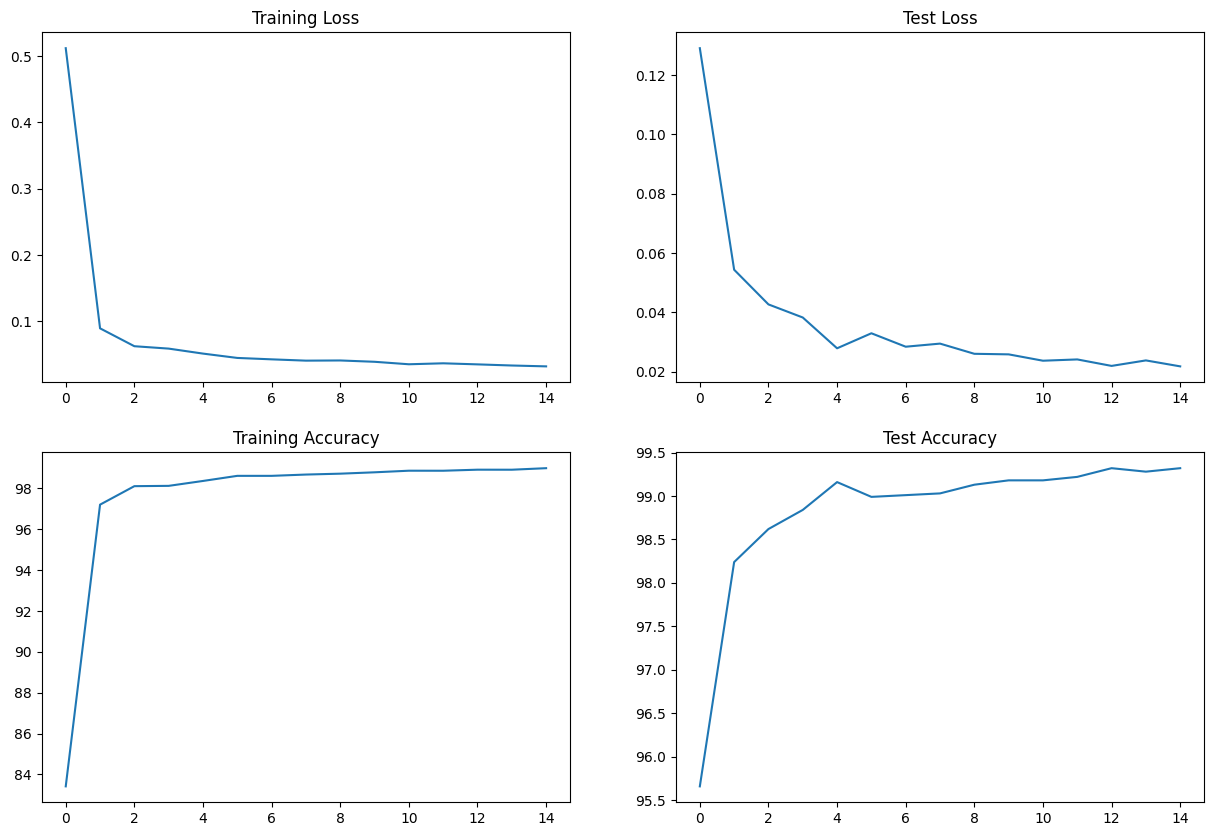

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

---

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    #transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# set seed
torch.manual_seed(1)

batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0.05

model = Model_6(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  if epoch==4:
    scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.1141 Batch_id=117 Accuracy=83.89: 100%|██████████| 118/118 [00:20<00:00,  5.83it/s]


Test set: Average loss: 0.0884, Accuracy: 9716/10000 (97.16%)

Epoch 2


Train: Loss=0.0236 Batch_id=117 Accuracy=97.99: 100%|██████████| 118/118 [00:21<00:00,  5.56it/s]


Test set: Average loss: 0.0478, Accuracy: 9842/10000 (98.42%)

Epoch 3


Train: Loss=0.0781 Batch_id=117 Accuracy=98.44: 100%|██████████| 118/118 [00:22<00:00,  5.33it/s]


Test set: Average loss: 0.0414, Accuracy: 9867/10000 (98.67%)

Epoch 4


Train: Loss=0.1878 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0309, Accuracy: 9896/10000 (98.96%)

Epoch 5


Train: Loss=0.0384 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0303, Accuracy: 9900/10000 (99.00%)

Epoch 6


Train: Loss=0.0170 Batch_id=117 Accuracy=98.98: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


Test set: Average loss: 0.0320, Accuracy: 9891/10000 (98.91%)

Epoch 7


Train: Loss=0.0088 Batch_id=117 Accuracy=98.98: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s]


Test set: Average loss: 0.0271, Accuracy: 9914/10000 (99.14%)

Epoch 8


Train: Loss=0.1002 Batch_id=117 Accuracy=99.05: 100%|██████████| 118/118 [00:22<00:00,  5.25it/s]


Test set: Average loss: 0.0310, Accuracy: 9895/10000 (98.95%)

Epoch 9


Train: Loss=0.0191 Batch_id=117 Accuracy=99.03: 100%|██████████| 118/118 [00:22<00:00,  5.25it/s]


Test set: Average loss: 0.0259, Accuracy: 9923/10000 (99.23%)

Epoch 10


Train: Loss=0.0687 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:22<00:00,  5.16it/s]


Test set: Average loss: 0.0300, Accuracy: 9907/10000 (99.07%)

Epoch 11


Train: Loss=0.0012 Batch_id=117 Accuracy=99.14: 100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


Test set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)

Epoch 12


Train: Loss=0.0255 Batch_id=117 Accuracy=99.13: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)

Epoch 13


Train: Loss=0.0048 Batch_id=117 Accuracy=99.27: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s]


Test set: Average loss: 0.0204, Accuracy: 9931/10000 (99.31%)

Epoch 14


Train: Loss=0.0399 Batch_id=117 Accuracy=99.28: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]


Test set: Average loss: 0.0268, Accuracy: 9922/10000 (99.22%)

Epoch 15


Train: Loss=0.0130 Batch_id=117 Accuracy=99.28: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)



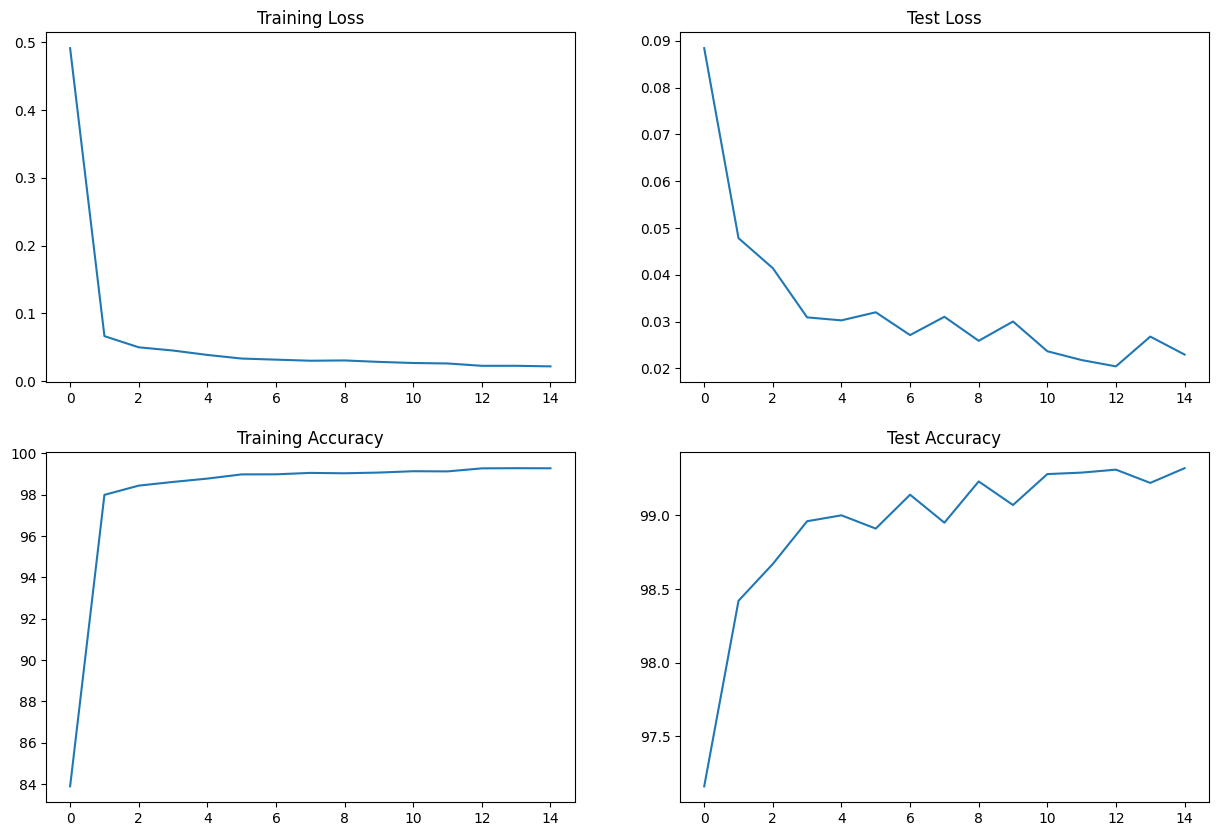

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

---

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0.05

model = Model_6(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  if epoch==4:
    scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.1281 Batch_id=117 Accuracy=83.00: 100%|██████████| 118/118 [00:22<00:00,  5.26it/s]


Test set: Average loss: 0.0953, Accuracy: 9703/10000 (97.03%)

Epoch 2


Train: Loss=0.0298 Batch_id=117 Accuracy=97.67: 100%|██████████| 118/118 [00:21<00:00,  5.39it/s]


Test set: Average loss: 0.0549, Accuracy: 9832/10000 (98.32%)

Epoch 3


Train: Loss=0.0150 Batch_id=117 Accuracy=98.39: 100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


Test set: Average loss: 0.0418, Accuracy: 9861/10000 (98.61%)

Epoch 4


Train: Loss=0.0147 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:21<00:00,  5.47it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0381, Accuracy: 9882/10000 (98.82%)

Epoch 5


Train: Loss=0.0668 Batch_id=117 Accuracy=98.77: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


Test set: Average loss: 0.0362, Accuracy: 9877/10000 (98.77%)

Epoch 6


Train: Loss=0.0173 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


Test set: Average loss: 0.0340, Accuracy: 9897/10000 (98.97%)

Epoch 7


Train: Loss=0.0131 Batch_id=117 Accuracy=98.89: 100%|██████████| 118/118 [00:21<00:00,  5.56it/s]


Test set: Average loss: 0.0348, Accuracy: 9896/10000 (98.96%)

Epoch 8


Train: Loss=0.0187 Batch_id=117 Accuracy=99.02: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]


Test set: Average loss: 0.0353, Accuracy: 9895/10000 (98.95%)

Epoch 9


Train: Loss=0.0314 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]


Test set: Average loss: 0.0281, Accuracy: 9910/10000 (99.10%)

Epoch 10


Train: Loss=0.0275 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


Test set: Average loss: 0.0318, Accuracy: 9901/10000 (99.01%)

Epoch 11


Train: Loss=0.0329 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:21<00:00,  5.52it/s]


Test set: Average loss: 0.0308, Accuracy: 9903/10000 (99.03%)

Epoch 12


Train: Loss=0.0508 Batch_id=117 Accuracy=99.25: 100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


Test set: Average loss: 0.0290, Accuracy: 9912/10000 (99.12%)

Epoch 13


Train: Loss=0.0445 Batch_id=117 Accuracy=99.18: 100%|██████████| 118/118 [00:21<00:00,  5.52it/s]


Test set: Average loss: 0.0274, Accuracy: 9906/10000 (99.06%)

Epoch 14


Train: Loss=0.0034 Batch_id=117 Accuracy=99.22: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


Test set: Average loss: 0.0267, Accuracy: 9920/10000 (99.20%)

Epoch 15


Train: Loss=0.0034 Batch_id=117 Accuracy=99.29: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


Test set: Average loss: 0.0280, Accuracy: 9910/10000 (99.10%)



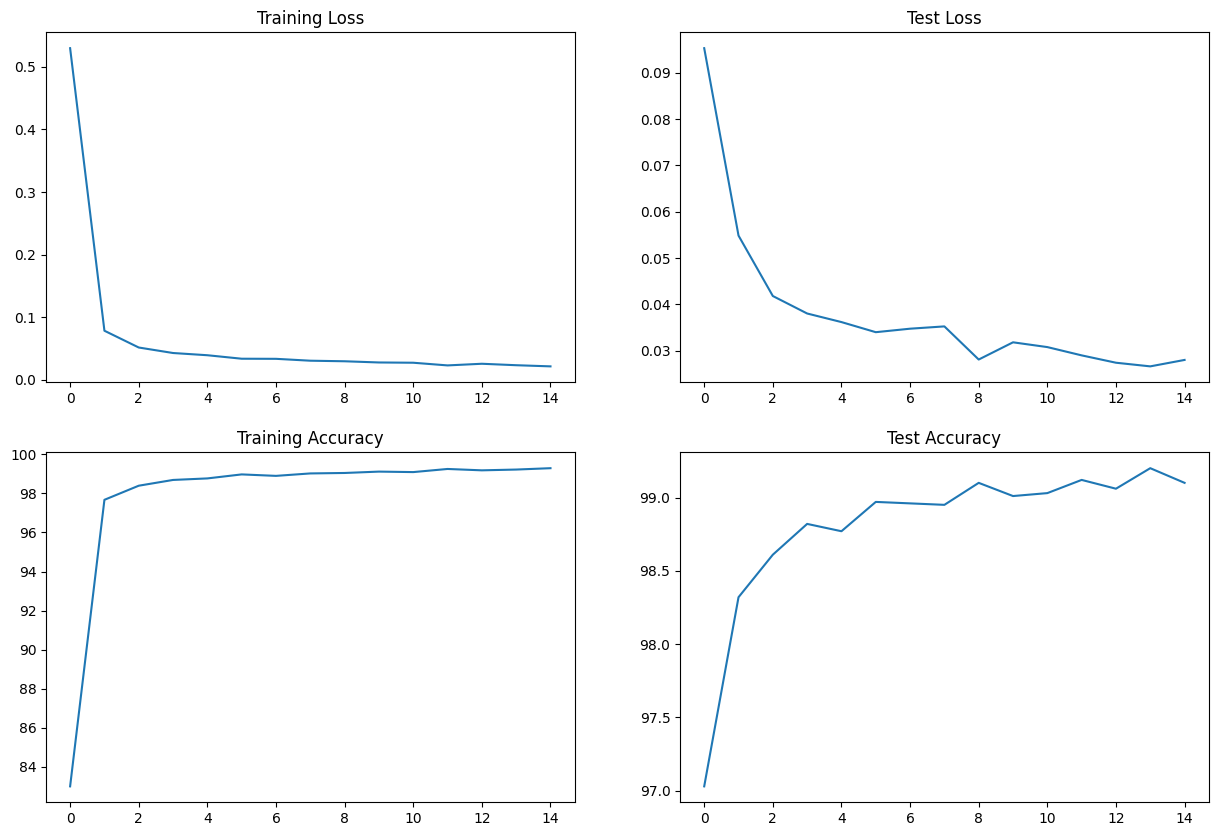

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

----

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# set seed
torch.manual_seed(1)

batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0.05

model = Model_6(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  if epoch==4:
    scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.0629 Batch_id=117 Accuracy=81.65: 100%|██████████| 118/118 [00:29<00:00,  4.06it/s]


Test set: Average loss: 0.0799, Accuracy: 9742/10000 (97.42%)

Epoch 2


Train: Loss=0.0243 Batch_id=117 Accuracy=97.06: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]


Test set: Average loss: 0.0462, Accuracy: 9841/10000 (98.41%)

Epoch 3


Train: Loss=0.0612 Batch_id=117 Accuracy=97.76: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]


Test set: Average loss: 0.0326, Accuracy: 9896/10000 (98.96%)

Epoch 4


Train: Loss=0.1799 Batch_id=117 Accuracy=97.96: 100%|██████████| 118/118 [00:28<00:00,  4.10it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0324, Accuracy: 9891/10000 (98.91%)

Epoch 5


Train: Loss=0.0320 Batch_id=117 Accuracy=98.13: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]


Test set: Average loss: 0.0275, Accuracy: 9905/10000 (99.05%)

Epoch 6


Train: Loss=0.0119 Batch_id=117 Accuracy=98.38: 100%|██████████| 118/118 [00:28<00:00,  4.12it/s]


Test set: Average loss: 0.0289, Accuracy: 9905/10000 (99.05%)

Epoch 7


Train: Loss=0.0183 Batch_id=117 Accuracy=98.48: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]


Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

Epoch 8


Train: Loss=0.0616 Batch_id=117 Accuracy=98.50: 100%|██████████| 118/118 [00:28<00:00,  4.10it/s]


Test set: Average loss: 0.0250, Accuracy: 9916/10000 (99.16%)

Epoch 9


Train: Loss=0.1044 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:28<00:00,  4.12it/s]


Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

Epoch 10


Train: Loss=0.0484 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:29<00:00,  4.06it/s]


Test set: Average loss: 0.0311, Accuracy: 9906/10000 (99.06%)

Epoch 11


Train: Loss=0.0085 Batch_id=117 Accuracy=98.64: 100%|██████████| 118/118 [00:29<00:00,  4.04it/s]


Test set: Average loss: 0.0251, Accuracy: 9919/10000 (99.19%)

Epoch 12


Train: Loss=0.0941 Batch_id=117 Accuracy=98.66: 100%|██████████| 118/118 [00:30<00:00,  3.90it/s]


Test set: Average loss: 0.0214, Accuracy: 9922/10000 (99.22%)

Epoch 13


Train: Loss=0.0281 Batch_id=117 Accuracy=98.74: 100%|██████████| 118/118 [00:28<00:00,  4.09it/s]


Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

Epoch 14


Train: Loss=0.0213 Batch_id=117 Accuracy=98.66: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]


Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

Epoch 15


Train: Loss=0.0563 Batch_id=117 Accuracy=98.75: 100%|██████████| 118/118 [00:28<00:00,  4.10it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)



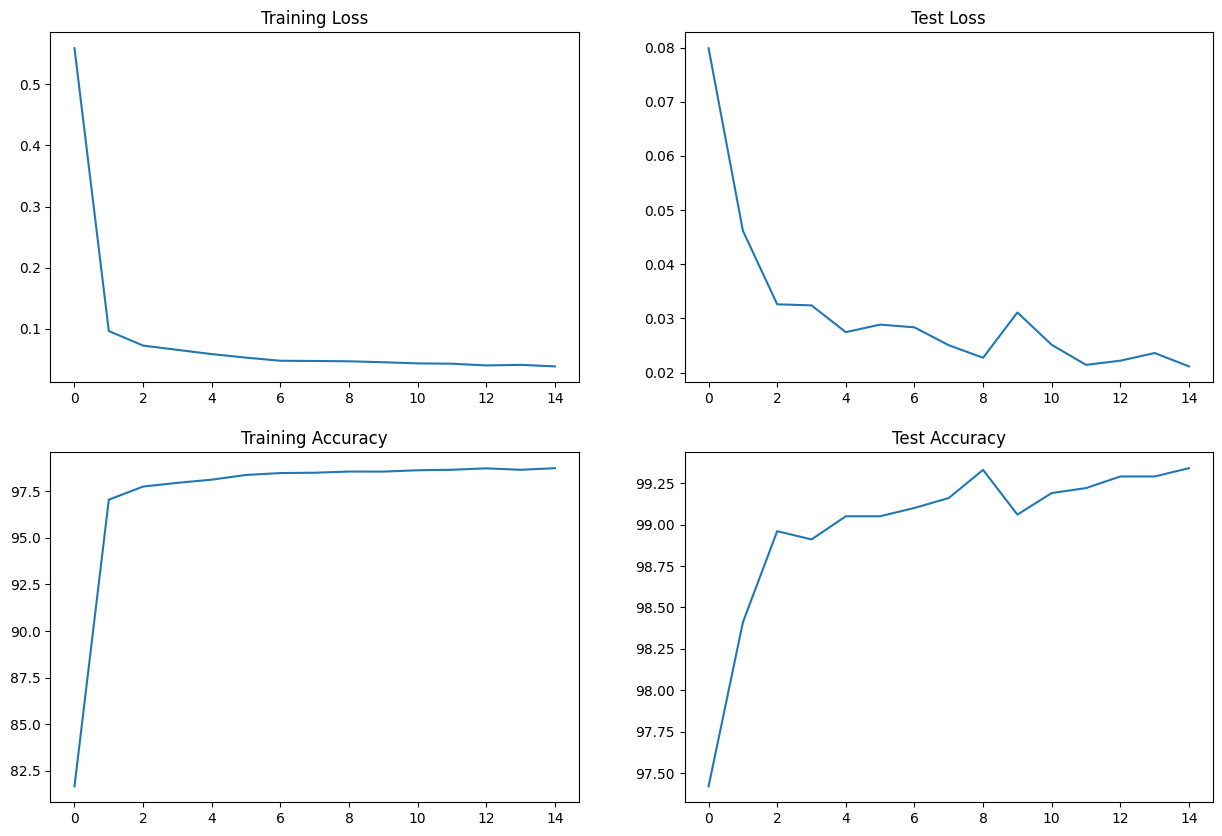

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0.05

model = Model_6(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.1695 Batch_id=117 Accuracy=80.61: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0995, Accuracy: 9704/10000 (97.04%)

Epoch 2


Train: Loss=0.1165 Batch_id=117 Accuracy=96.74: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0469, Accuracy: 9863/10000 (98.63%)

Epoch 3


Train: Loss=0.0158 Batch_id=117 Accuracy=97.64: 100%|██████████| 118/118 [00:30<00:00,  3.88it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0377, Accuracy: 9888/10000 (98.88%)

Epoch 4


Train: Loss=0.0660 Batch_id=117 Accuracy=97.99: 100%|██████████| 118/118 [00:30<00:00,  3.85it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0410, Accuracy: 9868/10000 (98.68%)

Epoch 5


Train: Loss=0.0926 Batch_id=117 Accuracy=98.42: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0256, Accuracy: 9922/10000 (99.22%)

Epoch 6


Train: Loss=0.0349 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

Epoch 7


Train: Loss=0.0226 Batch_id=117 Accuracy=98.53: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0252, Accuracy: 9918/10000 (99.18%)

Epoch 8


Train: Loss=0.0264 Batch_id=117 Accuracy=98.59: 100%|██████████| 118/118 [00:30<00:00,  3.86it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0241, Accuracy: 9921/10000 (99.21%)

Epoch 9


Train: Loss=0.0454 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:30<00:00,  3.83it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

Epoch 10


Train: Loss=0.0152 Batch_id=117 Accuracy=98.60: 100%|██████████| 118/118 [00:30<00:00,  3.85it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

Epoch 11


Train: Loss=0.0495 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:30<00:00,  3.83it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0235, Accuracy: 9924/10000 (99.24%)

Epoch 12


Train: Loss=0.0477 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:30<00:00,  3.84it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

Epoch 13


Train: Loss=0.0661 Batch_id=117 Accuracy=98.59: 100%|██████████| 118/118 [00:32<00:00,  3.60it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0234, Accuracy: 9926/10000 (99.26%)

Epoch 14


Train: Loss=0.0226 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:31<00:00,  3.80it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)

Epoch 15


Train: Loss=0.0095 Batch_id=117 Accuracy=98.67: 100%|██████████| 118/118 [00:30<00:00,  3.83it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)



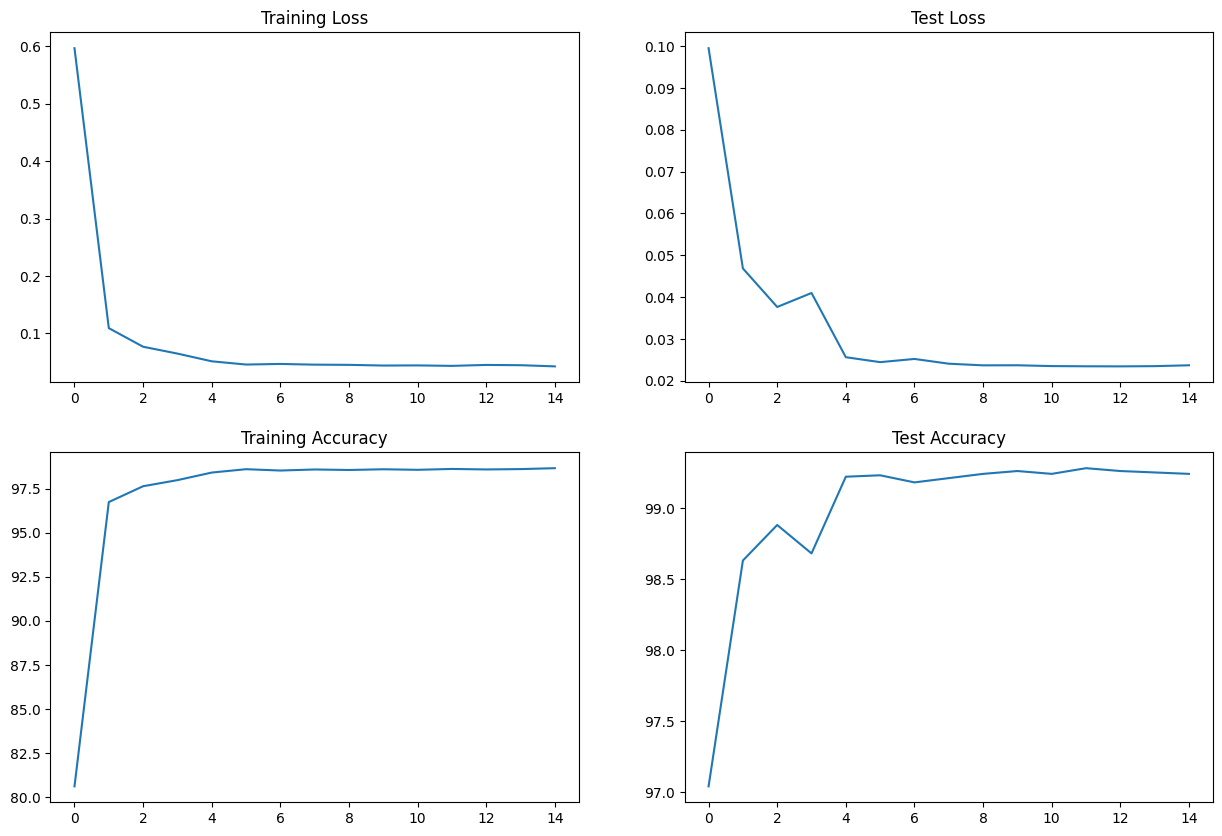

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

---

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0.05

model = Model_6(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.1524 Batch_id=117 Accuracy=81.62: 100%|██████████| 118/118 [00:29<00:00,  4.02it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.1140, Accuracy: 9622/10000 (96.22%)

Epoch 2


Train: Loss=0.0479 Batch_id=117 Accuracy=96.89: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0534, Accuracy: 9832/10000 (98.32%)

Epoch 3


Train: Loss=0.0586 Batch_id=117 Accuracy=97.67: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0430, Accuracy: 9857/10000 (98.57%)

Epoch 4


Train: Loss=0.1183 Batch_id=117 Accuracy=98.20: 100%|██████████| 118/118 [00:31<00:00,  3.80it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0279, Accuracy: 9910/10000 (99.10%)

Epoch 5


Train: Loss=0.0343 Batch_id=117 Accuracy=98.28: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0277, Accuracy: 9914/10000 (99.14%)

Epoch 6


Train: Loss=0.0524 Batch_id=117 Accuracy=98.36: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0277, Accuracy: 9908/10000 (99.08%)

Epoch 7


Train: Loss=0.1109 Batch_id=117 Accuracy=98.39: 100%|██████████| 118/118 [00:30<00:00,  3.90it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0271, Accuracy: 9910/10000 (99.10%)

Epoch 8


Train: Loss=0.0248 Batch_id=117 Accuracy=98.36: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0266, Accuracy: 9914/10000 (99.14%)

Epoch 9


Train: Loss=0.0145 Batch_id=117 Accuracy=98.49: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0262, Accuracy: 9916/10000 (99.16%)

Epoch 10


Train: Loss=0.0776 Batch_id=117 Accuracy=98.41: 100%|██████████| 118/118 [00:28<00:00,  4.10it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0264, Accuracy: 9915/10000 (99.15%)

Epoch 11


Train: Loss=0.0356 Batch_id=117 Accuracy=98.44: 100%|██████████| 118/118 [00:29<00:00,  4.02it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0261, Accuracy: 9916/10000 (99.16%)

Epoch 12


Train: Loss=0.0184 Batch_id=117 Accuracy=98.39: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Test set: Average loss: 0.0264, Accuracy: 9915/10000 (99.15%)

Epoch 13


Train: Loss=0.0257 Batch_id=117 Accuracy=98.43: 100%|██████████| 118/118 [00:29<00:00,  4.06it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Test set: Average loss: 0.0264, Accuracy: 9913/10000 (99.13%)

Epoch 14


Train: Loss=0.0167 Batch_id=117 Accuracy=98.36: 100%|██████████| 118/118 [00:28<00:00,  4.11it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

Epoch 15


Train: Loss=0.0226 Batch_id=117 Accuracy=98.39: 100%|██████████| 118/118 [00:28<00:00,  4.13it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Test set: Average loss: 0.0263, Accuracy: 9915/10000 (99.15%)



---

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0.05

model = Model_6(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.1963 Batch_id=117 Accuracy=80.84: 100%|██████████| 118/118 [00:28<00:00,  4.13it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.1321, Accuracy: 9559/10000 (95.59%)

Epoch 2


Train: Loss=0.1773 Batch_id=117 Accuracy=96.82: 100%|██████████| 118/118 [00:28<00:00,  4.07it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0697, Accuracy: 9779/10000 (97.79%)

Epoch 3


Train: Loss=0.0310 Batch_id=117 Accuracy=97.68: 100%|██████████| 118/118 [00:28<00:00,  4.16it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0449, Accuracy: 9857/10000 (98.57%)

Epoch 4


Train: Loss=0.0427 Batch_id=117 Accuracy=97.91: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0372, Accuracy: 9879/10000 (98.79%)

Epoch 5


Train: Loss=0.0288 Batch_id=117 Accuracy=98.16: 100%|██████████| 118/118 [00:28<00:00,  4.15it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0318, Accuracy: 9897/10000 (98.97%)

Epoch 6


Train: Loss=0.0832 Batch_id=117 Accuracy=98.48: 100%|██████████| 118/118 [00:28<00:00,  4.15it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0254, Accuracy: 9912/10000 (99.12%)

Epoch 7


Train: Loss=0.0450 Batch_id=117 Accuracy=98.59: 100%|██████████| 118/118 [00:28<00:00,  4.16it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0251, Accuracy: 9919/10000 (99.19%)

Epoch 8


Train: Loss=0.0233 Batch_id=117 Accuracy=98.70: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0244, Accuracy: 9917/10000 (99.17%)

Epoch 9


Train: Loss=0.0476 Batch_id=117 Accuracy=98.64: 100%|██████████| 118/118 [00:28<00:00,  4.20it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0242, Accuracy: 9917/10000 (99.17%)

Epoch 10


Train: Loss=0.0114 Batch_id=117 Accuracy=98.67: 100%|██████████| 118/118 [00:28<00:00,  4.10it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0238, Accuracy: 9919/10000 (99.19%)

Epoch 11


Train: Loss=0.0382 Batch_id=117 Accuracy=98.75: 100%|██████████| 118/118 [00:29<00:00,  4.03it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0236, Accuracy: 9922/10000 (99.22%)

Epoch 12


Train: Loss=0.0195 Batch_id=117 Accuracy=98.71: 100%|██████████| 118/118 [00:30<00:00,  3.87it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0240, Accuracy: 9923/10000 (99.23%)

Epoch 13


Train: Loss=0.0326 Batch_id=117 Accuracy=98.70: 100%|██████████| 118/118 [00:30<00:00,  3.82it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

Epoch 14


Train: Loss=0.0218 Batch_id=117 Accuracy=98.77: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0237, Accuracy: 9922/10000 (99.22%)

Epoch 15


Train: Loss=0.0557 Batch_id=117 Accuracy=98.76: 100%|██████████| 118/118 [00:30<00:00,  3.92it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0234, Accuracy: 9923/10000 (99.23%)



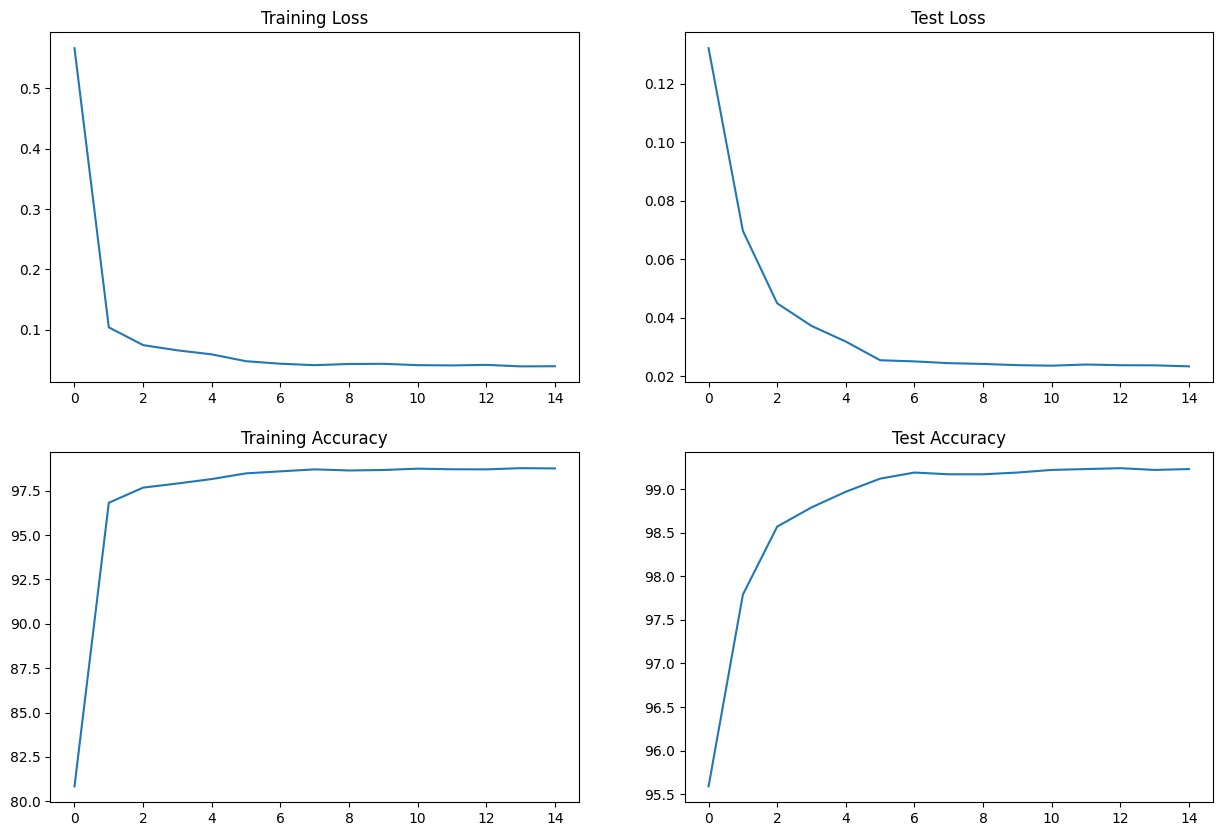

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model_7(nn.Module):

    def __init__(self, dropout_value=0):
        super(Model_7, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # input_size = 28x28x1, output_size = 26x26x16, RF = 3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # input_size = 26x26x16, output_size = 24x24x24, RF = 5x5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 24x24x24, output_size = 24x24x10, RF = 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24x24x10, output_size = 12x12x10, RF = 6x6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # input_size = 12x12x10, output_size = 10x10x14, RF = 10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # input_size = 6x6x16, output_size = 1x1x16, RF = 38x38

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x32, RF = 38x38

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x32, RF = 38x38

        self.dropout = nn.Dropout(dropout_value)


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary

model = Model_7().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 14, 24, 24]           1,008
              ReLU-6           [-1, 14, 24, 24]               0
       BatchNorm2d-7           [-1, 14, 24, 24]              28
           Dropout-8           [-1, 14, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             140
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
    

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    #transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# set seed
torch.manual_seed(1)

batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0 #.05

model = Model_7(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  #scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Epoch 1


Train: Loss=0.0996 Batch_id=117 Accuracy=85.17: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


Test set: Average loss: 0.1631, Accuracy: 9509/10000 (95.09%)

Epoch 2


Train: Loss=0.0364 Batch_id=117 Accuracy=98.00: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


Test set: Average loss: 0.0541, Accuracy: 9833/10000 (98.33%)

Epoch 3


Train: Loss=0.1695 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:21<00:00,  5.38it/s]


Test set: Average loss: 0.0441, Accuracy: 9854/10000 (98.54%)

Epoch 4


Train: Loss=0.0391 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


Test set: Average loss: 0.0378, Accuracy: 9893/10000 (98.93%)

Epoch 5


Train: Loss=0.0258 Batch_id=117 Accuracy=99.02: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s]


Test set: Average loss: 0.0381, Accuracy: 9889/10000 (98.89%)

Epoch 6


Train: Loss=0.0136 Batch_id=117 Accuracy=99.01: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s]


Test set: Average loss: 0.0357, Accuracy: 9879/10000 (98.79%)

Epoch 7


Train: Loss=0.0276 Batch_id=117 Accuracy=99.21: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]


Test set: Average loss: 0.0299, Accuracy: 9908/10000 (99.08%)

Epoch 8


Train: Loss=0.0548 Batch_id=117 Accuracy=99.24: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s]


Test set: Average loss: 0.0287, Accuracy: 9908/10000 (99.08%)

Epoch 9


Train: Loss=0.0077 Batch_id=117 Accuracy=99.28: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s]


Test set: Average loss: 0.0318, Accuracy: 9897/10000 (98.97%)

Epoch 10


Train: Loss=0.0552 Batch_id=117 Accuracy=99.36: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


Test set: Average loss: 0.0251, Accuracy: 9916/10000 (99.16%)

Epoch 11


Train: Loss=0.0032 Batch_id=117 Accuracy=99.43: 100%|██████████| 118/118 [00:22<00:00,  5.24it/s]


Test set: Average loss: 0.0248, Accuracy: 9920/10000 (99.20%)

Epoch 12


Train: Loss=0.0199 Batch_id=117 Accuracy=99.53: 100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


Test set: Average loss: 0.0271, Accuracy: 9926/10000 (99.26%)

Epoch 13


Train: Loss=0.0038 Batch_id=117 Accuracy=99.55: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


Test set: Average loss: 0.0308, Accuracy: 9912/10000 (99.12%)

Epoch 14


Train: Loss=0.0014 Batch_id=117 Accuracy=99.59: 100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

Epoch 15


Train: Loss=0.0230 Batch_id=117 Accuracy=99.58: 100%|██████████| 118/118 [00:21<00:00,  5.39it/s]


Test set: Average loss: 0.0247, Accuracy: 9927/10000 (99.27%)



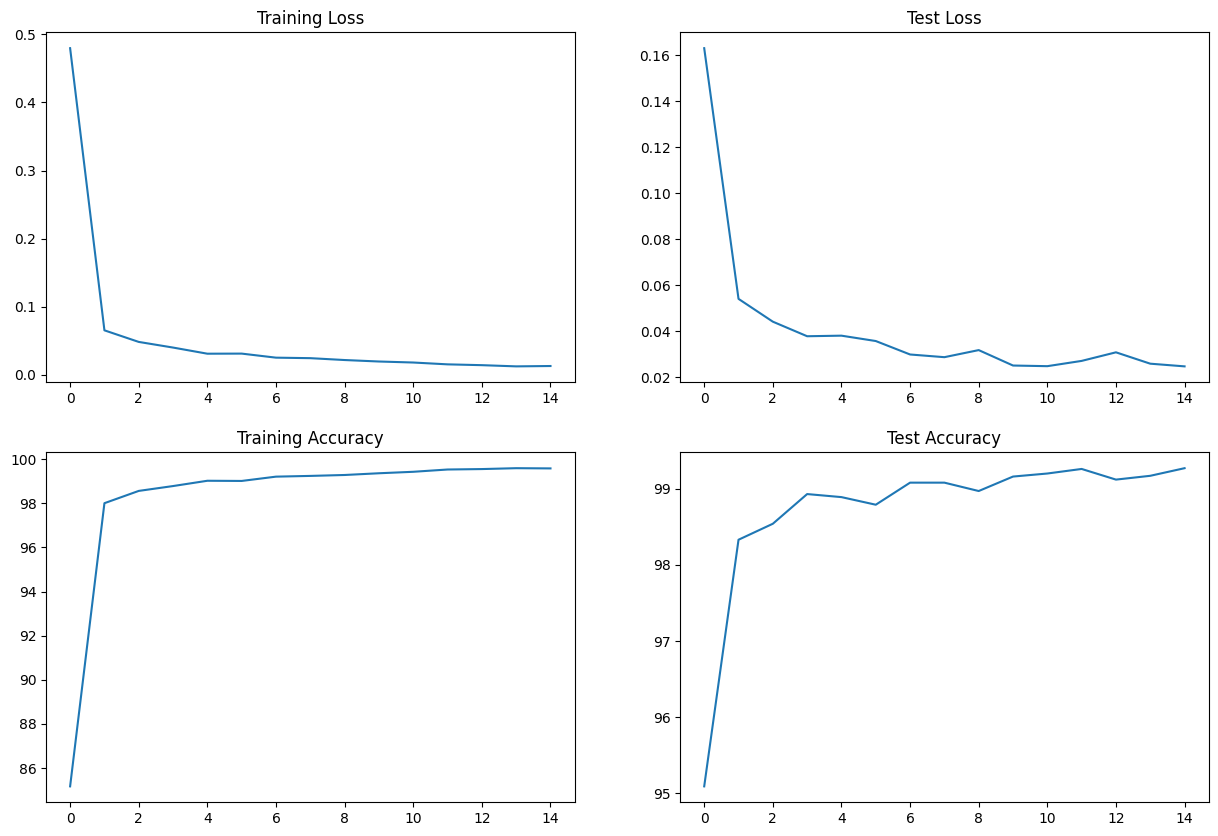

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0 #.05

model = Model_7(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  #scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Epoch 1


Train: Loss=0.3715 Batch_id=117 Accuracy=62.69: 100%|██████████| 118/118 [00:22<00:00,  5.36it/s]


Test set: Average loss: 0.4115, Accuracy: 9057/10000 (90.57%)

Epoch 2


Train: Loss=0.1962 Batch_id=117 Accuracy=94.96: 100%|██████████| 118/118 [00:21<00:00,  5.61it/s]


Test set: Average loss: 0.1165, Accuracy: 9717/10000 (97.17%)

Epoch 3


Train: Loss=0.1388 Batch_id=117 Accuracy=97.25: 100%|██████████| 118/118 [00:20<00:00,  5.62it/s]


Test set: Average loss: 0.0937, Accuracy: 9751/10000 (97.51%)

Epoch 4


Train: Loss=0.1514 Batch_id=117 Accuracy=97.95: 100%|██████████| 118/118 [00:21<00:00,  5.57it/s]


Test set: Average loss: 0.0754, Accuracy: 9789/10000 (97.89%)

Epoch 5


Train: Loss=0.1189 Batch_id=117 Accuracy=98.22: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


Test set: Average loss: 0.0776, Accuracy: 9777/10000 (97.77%)

Epoch 6


Train: Loss=0.0439 Batch_id=117 Accuracy=98.45: 100%|██████████| 118/118 [00:21<00:00,  5.57it/s]


Test set: Average loss: 0.0530, Accuracy: 9861/10000 (98.61%)

Epoch 7


Train: Loss=0.0370 Batch_id=117 Accuracy=98.65: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


Test set: Average loss: 0.0502, Accuracy: 9862/10000 (98.62%)

Epoch 8


Train: Loss=0.0479 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


Test set: Average loss: 0.0470, Accuracy: 9856/10000 (98.56%)

Epoch 9


Train: Loss=0.0396 Batch_id=117 Accuracy=98.86: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]


Test set: Average loss: 0.0392, Accuracy: 9879/10000 (98.79%)

Epoch 10


Train: Loss=0.0641 Batch_id=117 Accuracy=98.99: 100%|██████████| 118/118 [00:21<00:00,  5.61it/s]


Test set: Average loss: 0.0401, Accuracy: 9875/10000 (98.75%)

Epoch 11


Train: Loss=0.1004 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]


Test set: Average loss: 0.0396, Accuracy: 9865/10000 (98.65%)

Epoch 12


Train: Loss=0.0204 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:22<00:00,  5.34it/s]


Test set: Average loss: 0.0350, Accuracy: 9890/10000 (98.90%)

Epoch 13


Train: Loss=0.0389 Batch_id=117 Accuracy=99.13: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s]


Test set: Average loss: 0.0337, Accuracy: 9894/10000 (98.94%)

Epoch 14


Train: Loss=0.0708 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


Test set: Average loss: 0.0388, Accuracy: 9872/10000 (98.72%)

Epoch 15


Train: Loss=0.0312 Batch_id=117 Accuracy=99.22: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s]


Test set: Average loss: 0.0338, Accuracy: 9899/10000 (98.99%)



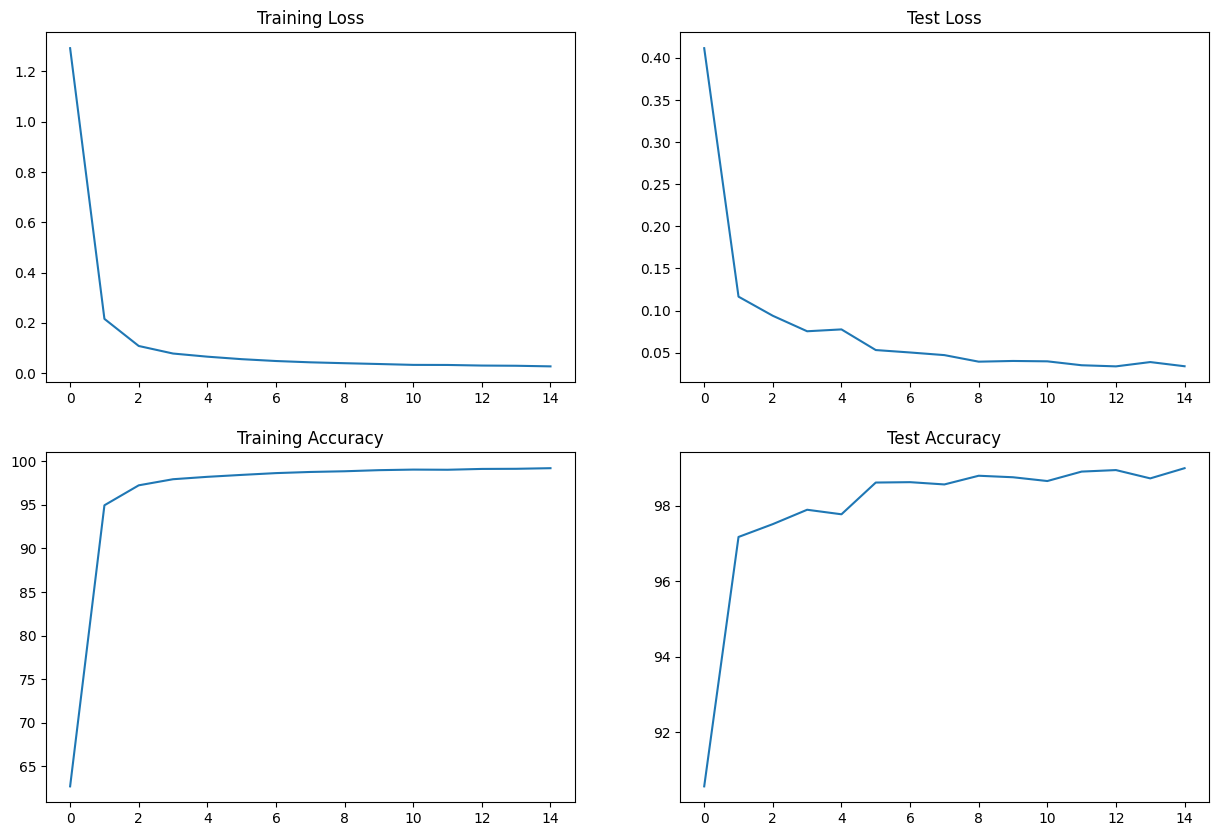

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0 #.05

model = Model_7(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  if epoch==4:
    scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.0374 Batch_id=117 Accuracy=85.63: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


Test set: Average loss: 0.1037, Accuracy: 9665/10000 (96.65%)

Epoch 2


Train: Loss=0.0681 Batch_id=117 Accuracy=98.17: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


Test set: Average loss: 0.0510, Accuracy: 9845/10000 (98.45%)

Epoch 3


Train: Loss=0.0337 Batch_id=117 Accuracy=98.70: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s]


Test set: Average loss: 0.0566, Accuracy: 9808/10000 (98.08%)

Epoch 4


Train: Loss=0.0147 Batch_id=117 Accuracy=98.95: 100%|██████████| 118/118 [00:20<00:00,  5.62it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0343, Accuracy: 9895/10000 (98.95%)

Epoch 5


Train: Loss=0.0299 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]


Test set: Average loss: 0.0287, Accuracy: 9905/10000 (99.05%)

Epoch 6


Train: Loss=0.0176 Batch_id=117 Accuracy=99.22: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


Test set: Average loss: 0.0340, Accuracy: 9893/10000 (98.93%)

Epoch 7


Train: Loss=0.0766 Batch_id=117 Accuracy=99.30: 100%|██████████| 118/118 [00:21<00:00,  5.52it/s]


Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

Epoch 8


Train: Loss=0.0354 Batch_id=117 Accuracy=99.35: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


Test set: Average loss: 0.0238, Accuracy: 9909/10000 (99.09%)

Epoch 9


Train: Loss=0.0780 Batch_id=117 Accuracy=99.43: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0298, Accuracy: 9904/10000 (99.04%)

Epoch 10


Train: Loss=0.0165 Batch_id=117 Accuracy=99.35: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s]


Test set: Average loss: 0.0249, Accuracy: 9912/10000 (99.12%)

Epoch 11


Train: Loss=0.0061 Batch_id=117 Accuracy=99.49: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


Test set: Average loss: 0.0224, Accuracy: 9924/10000 (99.24%)

Epoch 12


Train: Loss=0.0155 Batch_id=117 Accuracy=99.56: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Test set: Average loss: 0.0259, Accuracy: 9913/10000 (99.13%)

Epoch 13


Train: Loss=0.0122 Batch_id=117 Accuracy=99.61: 100%|██████████| 118/118 [00:21<00:00,  5.37it/s]


Test set: Average loss: 0.0270, Accuracy: 9909/10000 (99.09%)

Epoch 14


Train: Loss=0.0298 Batch_id=117 Accuracy=99.55: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


Test set: Average loss: 0.0246, Accuracy: 9923/10000 (99.23%)

Epoch 15


Train: Loss=0.0038 Batch_id=117 Accuracy=99.63: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s]


Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)



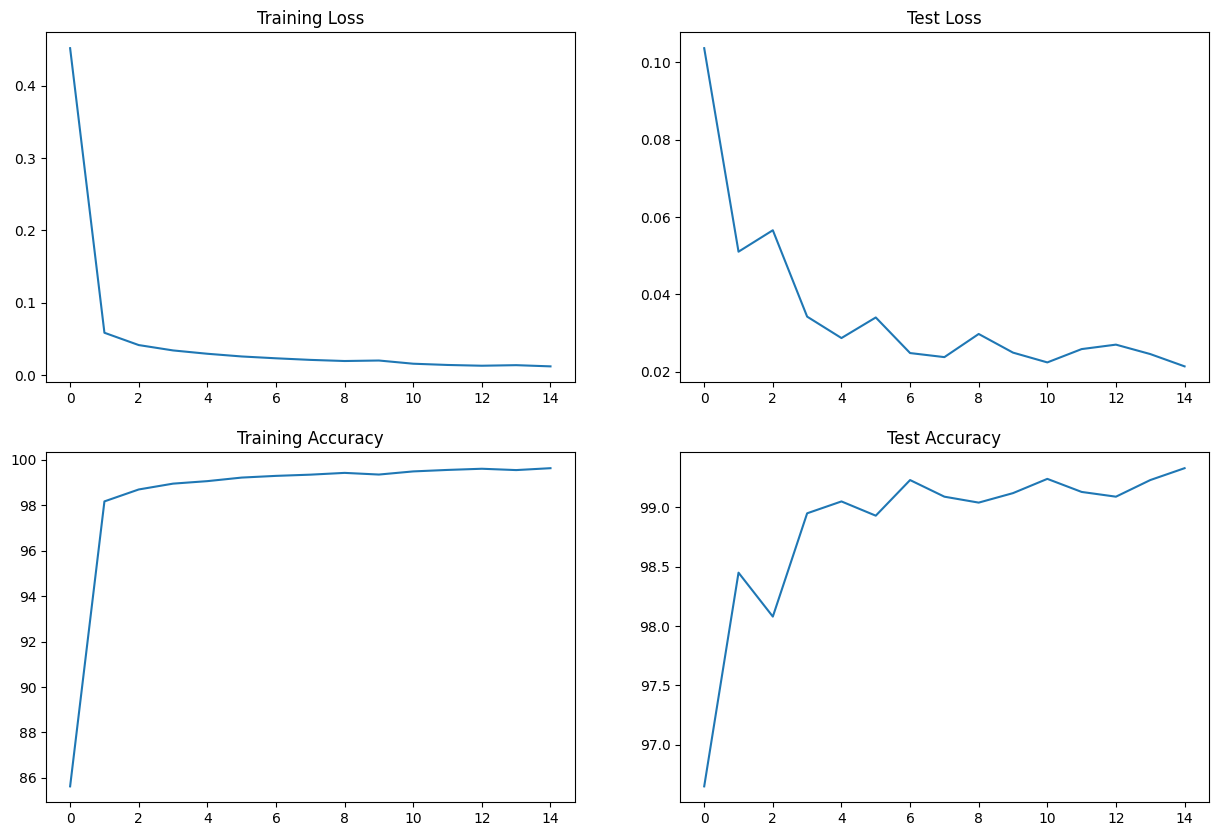

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0.05

model = Model_7(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  if epoch==4:
    scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.0529 Batch_id=117 Accuracy=83.93: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s]


Test set: Average loss: 0.1039, Accuracy: 9660/10000 (96.60%)

Epoch 2


Train: Loss=0.0653 Batch_id=117 Accuracy=97.71: 100%|██████████| 118/118 [00:21<00:00,  5.56it/s]


Test set: Average loss: 0.0536, Accuracy: 9829/10000 (98.29%)

Epoch 3


Train: Loss=0.0636 Batch_id=117 Accuracy=98.32: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s]


Test set: Average loss: 0.0429, Accuracy: 9852/10000 (98.52%)

Epoch 4


Train: Loss=0.0149 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0340, Accuracy: 9892/10000 (98.92%)

Epoch 5


Train: Loss=0.0121 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s]


Test set: Average loss: 0.0371, Accuracy: 9886/10000 (98.86%)

Epoch 6


Train: Loss=0.0132 Batch_id=117 Accuracy=98.88: 100%|██████████| 118/118 [00:21<00:00,  5.55it/s]


Test set: Average loss: 0.0447, Accuracy: 9862/10000 (98.62%)

Epoch 7


Train: Loss=0.0055 Batch_id=117 Accuracy=98.94: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


Test set: Average loss: 0.0287, Accuracy: 9901/10000 (99.01%)

Epoch 8


Train: Loss=0.0723 Batch_id=117 Accuracy=99.03: 100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


Test set: Average loss: 0.0295, Accuracy: 9890/10000 (98.90%)

Epoch 9


Train: Loss=0.0614 Batch_id=117 Accuracy=99.02: 100%|██████████| 118/118 [00:21<00:00,  5.37it/s]


Test set: Average loss: 0.0257, Accuracy: 9903/10000 (99.03%)

Epoch 10


Train: Loss=0.0985 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:21<00:00,  5.39it/s]


Test set: Average loss: 0.0274, Accuracy: 9911/10000 (99.11%)

Epoch 11


Train: Loss=0.0045 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


Test set: Average loss: 0.0269, Accuracy: 9903/10000 (99.03%)

Epoch 12


Train: Loss=0.0018 Batch_id=117 Accuracy=99.22: 100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

Epoch 13


Train: Loss=0.0066 Batch_id=117 Accuracy=99.26: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


Test set: Average loss: 0.0346, Accuracy: 9878/10000 (98.78%)

Epoch 14


Train: Loss=0.0234 Batch_id=117 Accuracy=99.30: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


Test set: Average loss: 0.0249, Accuracy: 9922/10000 (99.22%)

Epoch 15


Train: Loss=0.0281 Batch_id=117 Accuracy=99.28: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s]


Test set: Average loss: 0.0275, Accuracy: 9916/10000 (99.16%)



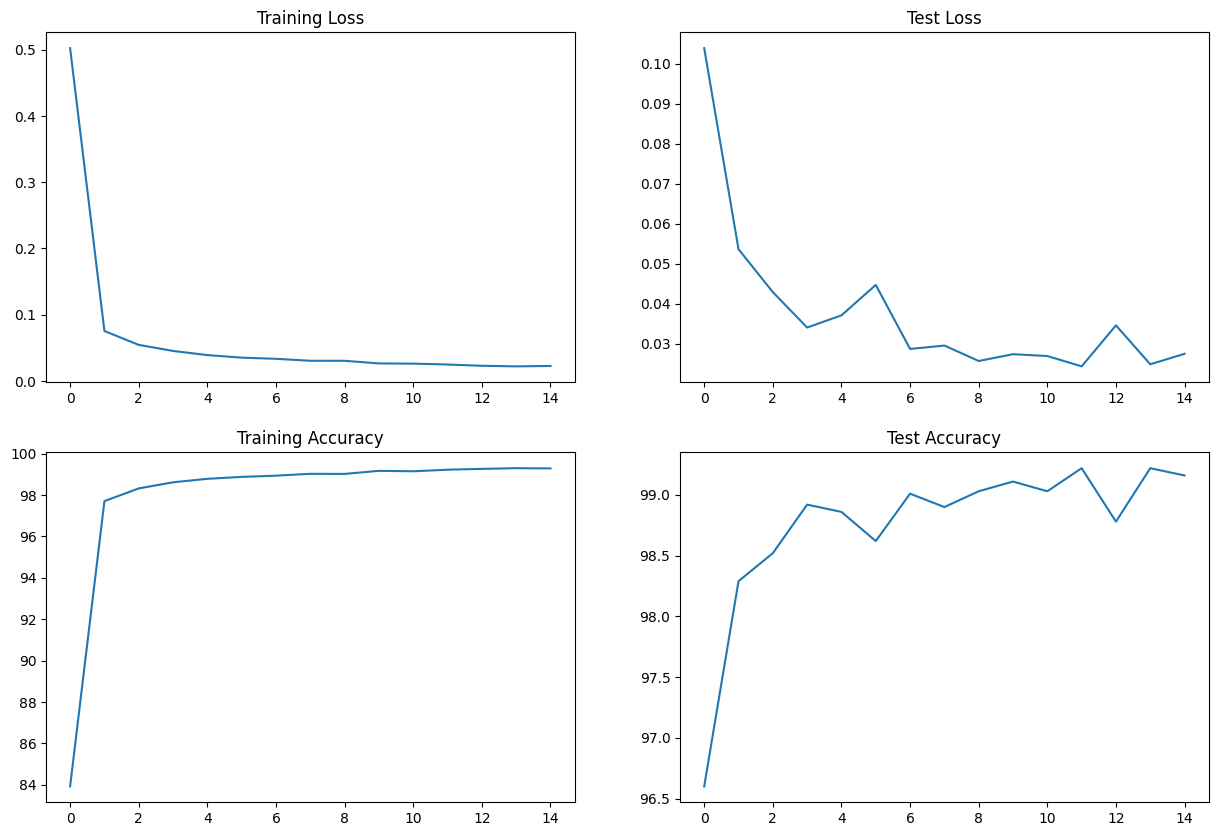

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# set seed
torch.manual_seed(1)

batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0.05

model = Model_7(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  if epoch==4:
    scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.0865 Batch_id=468 Accuracy=87.70: 100%|██████████| 469/469 [00:33<00:00, 13.98it/s]


Test set: Average loss: 0.0725, Accuracy: 9758/10000 (97.58%)

Epoch 2


Train: Loss=0.1077 Batch_id=468 Accuracy=96.29: 100%|██████████| 469/469 [00:31<00:00, 14.74it/s]


Test set: Average loss: 0.0454, Accuracy: 9842/10000 (98.42%)

Epoch 3


Train: Loss=0.1023 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]


Test set: Average loss: 0.0460, Accuracy: 9854/10000 (98.54%)

Epoch 4


Train: Loss=0.0671 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:30<00:00, 15.19it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0373, Accuracy: 9883/10000 (98.83%)

Epoch 5


Train: Loss=0.0174 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:32<00:00, 14.37it/s]


Test set: Average loss: 0.0314, Accuracy: 9906/10000 (99.06%)

Epoch 6


Train: Loss=0.0247 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]


Test set: Average loss: 0.0388, Accuracy: 9870/10000 (98.70%)

Epoch 7


Train: Loss=0.0542 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:31<00:00, 14.94it/s]


Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99.17%)

Epoch 8


Train: Loss=0.0522 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:31<00:00, 15.08it/s]


Test set: Average loss: 0.0378, Accuracy: 9879/10000 (98.79%)

Epoch 9


Train: Loss=0.0476 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:33<00:00, 14.14it/s]


Test set: Average loss: 0.0270, Accuracy: 9910/10000 (99.10%)

Epoch 10


Train: Loss=0.0584 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:32<00:00, 14.65it/s]


Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

Epoch 11


Train: Loss=0.0141 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:31<00:00, 15.03it/s]


Test set: Average loss: 0.0264, Accuracy: 9925/10000 (99.25%)

Epoch 12


Train: Loss=0.1363 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

Epoch 13


Train: Loss=0.0790 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:32<00:00, 14.27it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

Epoch 14


Train: Loss=0.0095 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:31<00:00, 14.98it/s]


Test set: Average loss: 0.0288, Accuracy: 9903/10000 (99.03%)

Epoch 15


Train: Loss=0.0664 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:31<00:00, 15.08it/s]


Test set: Average loss: 0.0273, Accuracy: 9912/10000 (99.12%)



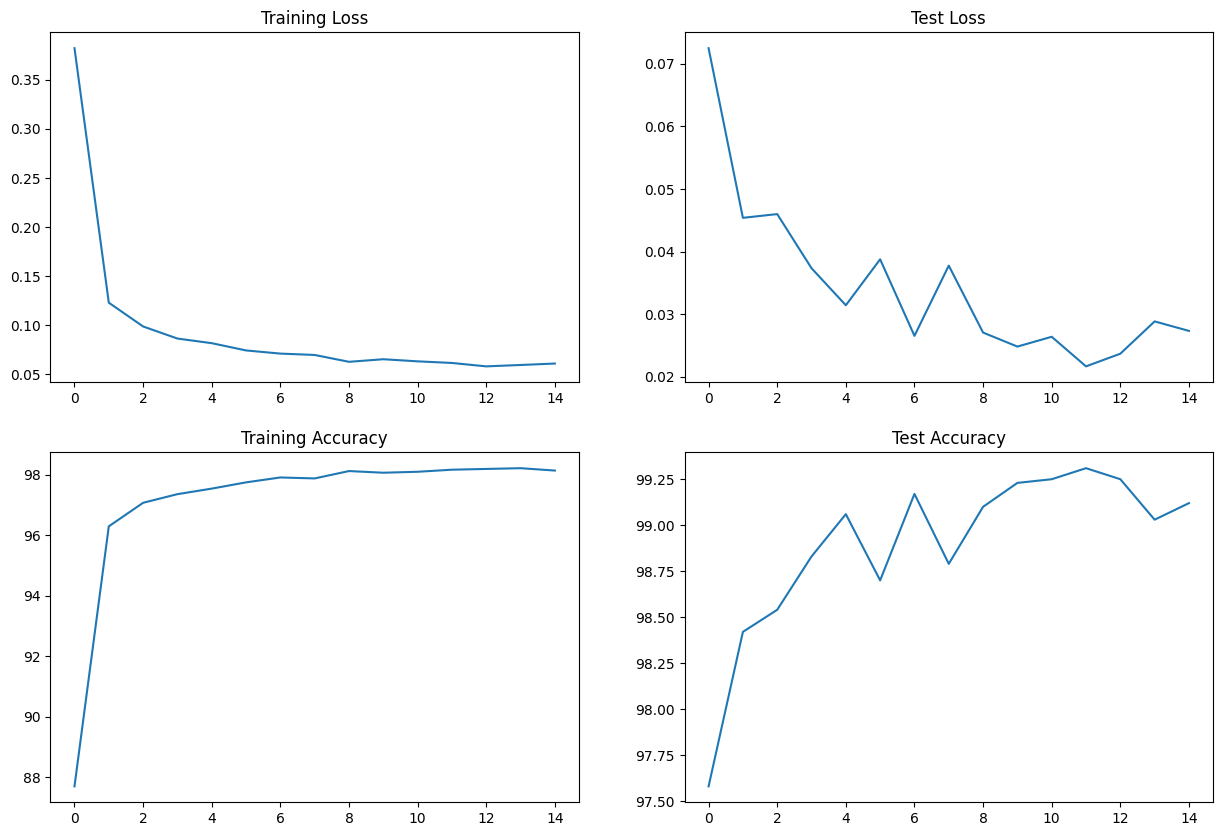

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0.05

model = Model_7(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.1322 Batch_id=468 Accuracy=89.18: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0502, Accuracy: 9838/10000 (98.38%)

Epoch 2


Train: Loss=0.1159 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0327, Accuracy: 9890/10000 (98.90%)

Epoch 3


Train: Loss=0.0532 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:33<00:00, 14.17it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0286, Accuracy: 9917/10000 (99.17%)

Epoch 4


Train: Loss=0.0535 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:33<00:00, 13.80it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0318, Accuracy: 9899/10000 (98.99%)

Epoch 5


Train: Loss=0.1066 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:32<00:00, 14.22it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0202, Accuracy: 9933/10000 (99.33%)

Epoch 6


Train: Loss=0.0813 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

Epoch 7


Train: Loss=0.0108 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:32<00:00, 14.34it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)

Epoch 8


Train: Loss=0.0686 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:34<00:00, 13.68it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)

Epoch 9


Train: Loss=0.0230 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:32<00:00, 14.25it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

Epoch 10


Train: Loss=0.0431 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0197, Accuracy: 9932/10000 (99.32%)

Epoch 11


Train: Loss=0.0999 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Test set: Average loss: 0.0190, Accuracy: 9936/10000 (99.36%)

Epoch 12


Train: Loss=0.1079 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:33<00:00, 14.07it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

Epoch 13


Train: Loss=0.0809 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.35%)

Epoch 14


Train: Loss=0.0260 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)

Epoch 15


Train: Loss=0.0853 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:31<00:00, 15.00it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Test set: Average loss: 0.0198, Accuracy: 9933/10000 (99.33%)



In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(20), ], p=0.1),
    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# set seed
torch.manual_seed(1)

batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 140164895.30it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18378955.22it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36986145.47it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21357095.03it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0.05

model = Model_7(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.0786 Batch_id=468 Accuracy=87.56: 100%|██████████| 469/469 [00:33<00:00, 14.01it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0528, Accuracy: 9831/10000 (98.31%)

Epoch 2


Train: Loss=0.1295 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0507, Accuracy: 9841/10000 (98.41%)

Epoch 3


Train: Loss=0.1093 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0531, Accuracy: 9841/10000 (98.41%)

Epoch 4


Train: Loss=0.1115 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0295, Accuracy: 9905/10000 (99.05%)

Epoch 5


Train: Loss=0.0523 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0334, Accuracy: 9895/10000 (98.95%)

Epoch 6


Train: Loss=0.0316 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0367, Accuracy: 9884/10000 (98.84%)

Epoch 7


Train: Loss=0.0307 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


Test set: Average loss: 0.0242, Accuracy: 9919/10000 (99.19%)

Epoch 8


Train: Loss=0.0396 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0372, Accuracy: 9878/10000 (98.78%)

Epoch 9


Train: Loss=0.0392 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0190, Accuracy: 9936/10000 (99.36%)

Epoch 10


Train: Loss=0.0800 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

Epoch 11


Train: Loss=0.0219 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)

Epoch 12


Train: Loss=0.0387 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0182, Accuracy: 9940/10000 (99.40%)

Epoch 13


Train: Loss=0.0534 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)

Epoch 14


Train: Loss=0.0075 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)

Epoch 15


Train: Loss=0.0594 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)



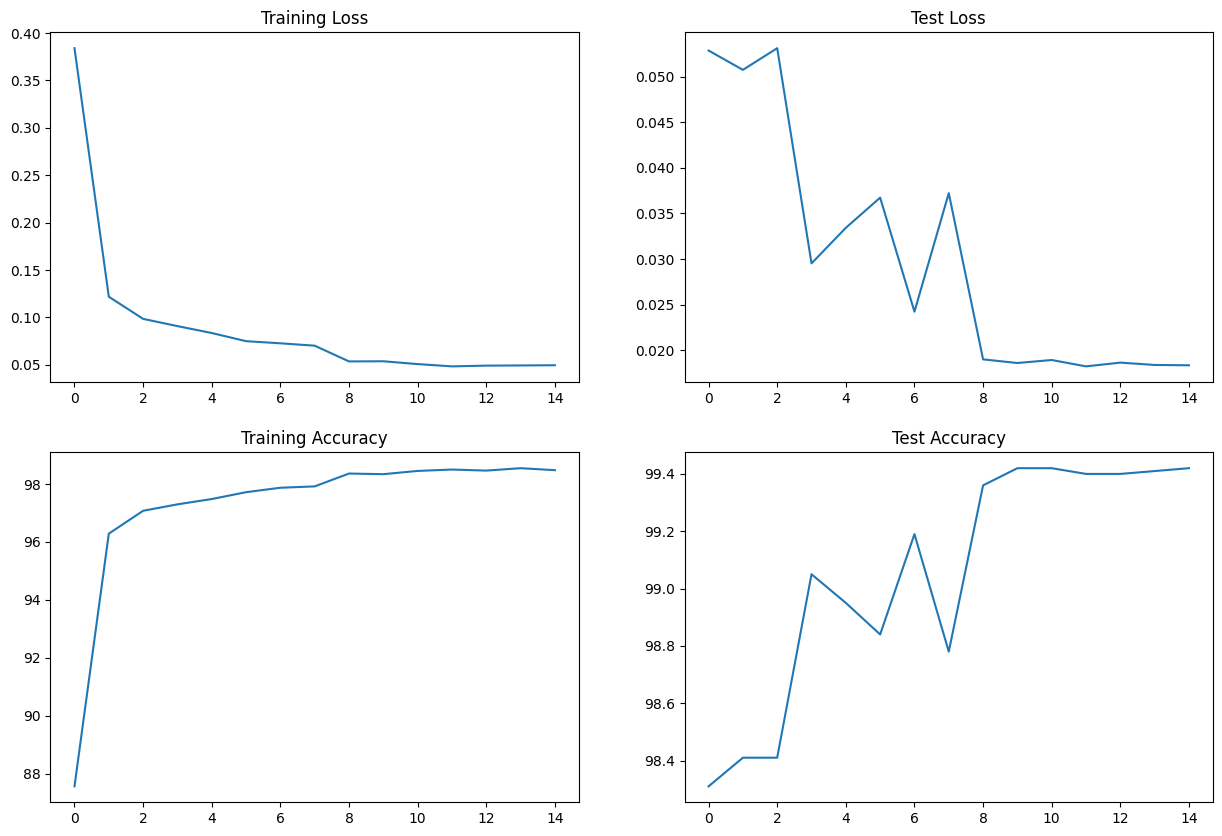

In [ ]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)